In [1]:
import turicreate as tc

In [2]:
import matplotlib.pyplot as plt

### Setting GPU for training model

In [3]:
tc.config.set_num_gpus(1) # 0: CPU, 1: GPU

In [4]:
# Currently TuriCreate supports using all CPUs or one GPU.
tc.config.get_num_gpus()

1

### Loading data to memory

In [ ]:
# 부모 폴더를 인자로 추가
%time data = tc.image_analysis.load_images('images', with_path=True)
#CPU times: 코드를 실행하는데 걸린 시간, Wall time: CPU가 작동한 시간

In [6]:
# 데이터 형태 확인
data.head()

path,image
/home/turi/turi/NSFW/data/images/drawings/0028 ...,Height: 2300 Width: 1080
/home/turi/turi/NSFW/data/images/drawings/009r ...,Height: 1023 Width: 720
/home/turi/turi/NSFW/data/images/drawings/00cu ...,Height: 354 Width: 236
/home/turi/turi/NSFW/data/images/drawings/00ga ...,Height: 1000 Width: 1414
/home/turi/turi/NSFW/data/images/drawings/00lj ...,Height: 1200 Width: 847
/home/turi/turi/NSFW/data/images/drawings/00op ...,Height: 764 Width: 1200
/home/turi/turi/NSFW/data/images/drawings/00sl ...,Height: 1336 Width: 1125
/home/turi/turi/NSFW/data/images/drawings/00yi ...,Height: 500 Width: 443
/home/turi/turi/NSFW/data/images/drawings/01.jpg ...,Height: 400 Width: 591
/home/turi/turi/NSFW/data/images/drawings/010t ...,Height: 553 Width: 1184


### Extracting the deep features from the images for memory garbage collection

In [ ]:
%%time
# 메모리 효율을 위해 feature extraction 실행, 이미지 데이터 제거
data['deep_features'] = tc.image_analysis.get_deep_features(data['image'], model_name="resnet-50", batch_size=128)
del data['image']    # allow images to be garbage collected
# squeeze net 사용하기 위해서는
# model_name='squeezenet_v1.1'
# model = tc.image_classifier.create(data, feature='deep_features', model="squeezenet_v1.1")

In [8]:
# 바뀐 데이터 확인(image를 로드하지 않기 때문에 출력 속도 향상)
data.head()

path,deep_features
/home/turi/turi/NSFW/data/images/drawings/0028 ...,"[0.19794777035713196,0.0, 0.9572954773902893, ..."
/home/turi/turi/NSFW/data/images/drawings/009r ...,"[0.6531480550765991, 0.0,1.4997583627700806, ..."
/home/turi/turi/NSFW/data/images/drawings/00cu ...,"[1.2259840965270996, 0.0,1.4122551679611206, ..."
/home/turi/turi/NSFW/data/images/drawings/00ga ...,"[0.17673170566558838,0.0, 0.737023651599884, ..."
/home/turi/turi/NSFW/data/images/drawings/00lj ...,"[0.23253639042377472,0.0, 0.4833354651927948, ..."
/home/turi/turi/NSFW/data/images/drawings/00op ...,"[0.11845016479492188,0.0, 1.64728581905365, ..."
/home/turi/turi/NSFW/data/images/drawings/00sl ...,"[0.07597087323665619,0.0, 0.5851982235908508, ..."
/home/turi/turi/NSFW/data/images/drawings/00yi ...,"[0.3022947609424591, 0.0,0.36984238028526306, ..."
/home/turi/turi/NSFW/data/images/drawings/01.jpg ...,"[0.2387317717075348, 0.0,1.3255895376205444, ..."
/home/turi/turi/NSFW/data/images/drawings/010t ...,"[0.018494056537747383,0.0, 0.5258007049560547, ..."


### Extracting label from path

In [9]:
# 데이터 클래스 추출
data['label'] = data['path'].apply(lambda x : x.split('/')[-2])

In [10]:
data.head()

path,deep_features,label
/home/turi/turi/NSFW/data/images/drawings/0028 ...,"[0.19794777035713196,0.0, 0.9572954773902893, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/009r ...,"[0.6531480550765991, 0.0,1.4997583627700806, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/00cu ...,"[1.2259840965270996, 0.0,1.4122551679611206, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/00ga ...,"[0.17673170566558838,0.0, 0.737023651599884, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/00lj ...,"[0.23253639042377472,0.0, 0.4833354651927948, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/00op ...,"[0.11845016479492188,0.0, 1.64728581905365, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/00sl ...,"[0.07597087323665619,0.0, 0.5851982235908508, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/00yi ...,"[0.3022947609424591, 0.0,0.36984238028526306, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/01.jpg ...,"[0.2387317717075348, 0.0,1.3255895376205444, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/010t ...,"[0.018494056537747383,0.0, 0.5258007049560547, ...",drawings


In [11]:
# 데이터 사이즈 확인
len(data['path'])

125214

### Counting the labels to check data balance

In [12]:
# 데이터 분포 확인
from collections import Counter
dist_data = Counter(data['label'])
dist_data

Counter({'drawings': 15205,
         'hentai': 4248,
         'neutral': 34910,
         'porn': 56968,
         'sexy': 13883})

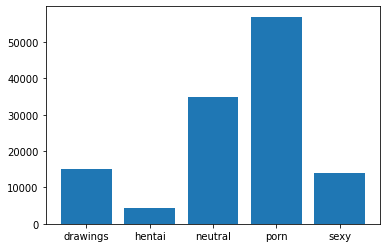

In [13]:
plt.bar(dist_data.keys(), dist_data.values())
plt.show()

### Split data to train and test

In [14]:
# 대량의 데이터로 학습하기 때문에 train 비중을 높게 나누기
train_data,test_data = data.random_split(0.9)

### Training model with resnet
- the more iterated model, the better accuracy in train set
- 230 iterations for overfitting

In [ ]:
%%time
model_ep260 = tc.image_classifier.create(train_data, feature='deep_features', target='label', max_iterations=260, batch_size=128) # , model='squeezenet_v1.1'

### Saving model

### Loading model

### Evaluating

In [17]:
# Inference에 소모되는 시간(테스트 데이터 개수 확인 필요)
print(len(test_data))
%time predictions = model.predict(test_data)

12318
CPU times: user 4.86 s, sys: 26.6 ms, total: 4.89 s
Wall time: 1.42 s


In [18]:
%%time
metrics = model.evaluate(test_data)

CPU times: user 23.9 s, sys: 399 ms, total: 24.3 s
Wall time: 9.51 s


In [19]:
print(metrics['accuracy'])

0.9205228121448287


##### confusion matrix

In [20]:
import seaborn as sns

In [21]:
cfs_mat = tc.evaluation.confusion_matrix(test_data['label'], predictions)

In [22]:
cfs_mat = cfs_mat.to_dataframe()

In [23]:
cfs_mat_ = cfs_mat.pivot_table(values='count', index='target_label', columns='predicted_label').fillna(0)

In [24]:
cfs_mat_

predicted_label,drawings,hentai,neutral,porn,sexy
target_label,,,,,
drawings,1226.0,52.0,123.0,2.0,0.0
hentai,93.0,278.0,5.0,9.0,3.0
neutral,86.0,3.0,3282.0,84.0,61.0
porn,3.0,1.0,63.0,5397.0,118.0
sexy,6.0,3.0,78.0,186.0,1156.0


<AxesSubplot:xlabel='predicted_label', ylabel='target_label'>

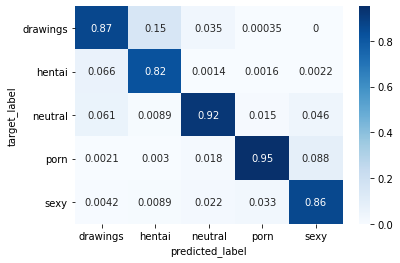

In [25]:
sns.heatmap(cfs_mat_/cfs_mat_.sum(), cmap='Blues', annot=True)

In [26]:
img1 = tc.image_analysis.load_images('https://keralakaumudi.com/web-news/en/2020/07/NMAN0162906/image/wamiqa-gabbii.1.694919.jpg')
img2 = tc.image_analysis.load_images('https://www.iwmbuzz.com/wp-content/uploads/2020/09/sexy-photos-naagin-fame-mouni-roy-shares-hot-pictures-in-black-bikini-920x518.jpg')
img3 = tc.image_analysis.load_images('https://i.ytimg.com/vi/KoqYHDiB6ew/maxresdefault.jpg')
img4 = tc.image_analysis.load_images('https://5.imimg.com/data5/UD/IK/NS/SELLER-42087980/women-s-sexy-lace-gathered-adjustable-bra-set-500x500.jpg')
img5 = tc.image_analysis.load_images('https://www.wikihow.com/images/thumb/d/d9/Be-Sexy-Step-1-Version-8.jpg/v4-460px-Be-Sexy-Step-1-Version-8.jpg')
img6 = tc.image_analysis.load_images('https://m.media-amazon.com/images/I/41pSW6lre5L.jpg')

Downloading https://keralakaumudi.com/web-news/en/2020/07/NMAN0162906/image/wamiqa-gabbii.1.694919.jpg to /var/tmp/turicreate-turi/2192814/3b68b45f-92da-4a40-b030-cfbcef977f6c.jpg

Downloading https://www.iwmbuzz.com/wp-content/uploads/2020/09/sexy-photos-naagin-fame-mouni-roy-shares-hot-pictures-in-black-bikini-920x518.jpg to /var/tmp/turicreate-turi/2192814/d855281c-6b6a-4701-879c-f3ae0e3303c0.jpg

Downloading https://i.ytimg.com/vi/KoqYHDiB6ew/maxresdefault.jpg to /var/tmp/turicreate-turi/2192814/b3a10cf1-340e-4157-926b-e29bbb7d3d54.jpg

Downloading https://5.imimg.com/data5/UD/IK/NS/SELLER-42087980/women-s-sexy-lace-gathered-adjustable-bra-set-500x500.jpg to /var/tmp/turicreate-turi/2192814/55114a5f-b10e-419e-a7bf-9ff9484fd1c3.jpg

Downloading https://www.wikihow.com/images/thumb/d/d9/Be-Sexy-Step-1-Version-8.jpg/v4-460px-Be-Sexy-Step-1-Version-8.jpg to /var/tmp/turicreate-turi/2192814/183e27ec-2b23-492f-ba11-7754dfe52e1a.jpg

Downloading https://m.media-amazon.com/images/I/41pSW6lre5L.jpg to /var/tmp/turicreate-turi/2192814/6a59173c-2a94-404e-a9b1-2be66bacb620.jpg

,SArray
0,

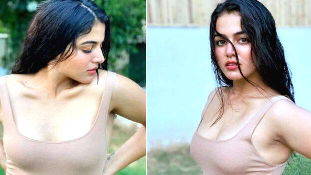

In [27]:
img1['image'].explore()

In [28]:
model.predict_topk(img1['image'])

id,class,probability
0,sexy,0.6155159573695956
0,porn,0.31906122475889187
0,neutral,0.06518107180010413


,SArray
0,

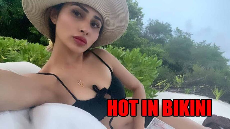

In [29]:
img2['image'].explore()

In [30]:
model.predict_topk(img2['image'])

id,class,probability
0,neutral,0.6353467804429602
0,porn,0.1814099980518115
0,sexy,0.13598465116731648


,SArray
0,

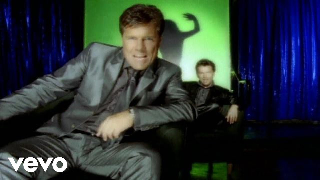

In [31]:
img3['image'].explore()

In [32]:
model.predict_topk(img3['image'])

id,class,probability
0,drawings,0.09980336544083923
0,neutral,0.8349475725148553
0,porn,0.06370195134686095


,SArray
0,

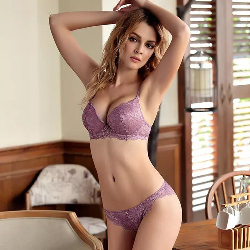

In [33]:
img4['image'].explore()

In [34]:
model.predict_topk(img4['image'])

id,class,probability
0,sexy,0.8111993996145174
0,porn,0.18527262426109453
0,neutral,0.0034340802209473806


,SArray
0,

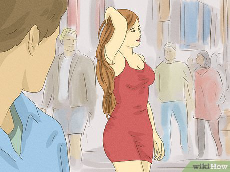

In [35]:
img5['image'].explore()

In [36]:
model.predict_topk(img5['image'])

id,class,probability
0,drawings,0.9840103633639398
0,hentai,0.015541367248151151
0,neutral,0.00037966777955688035


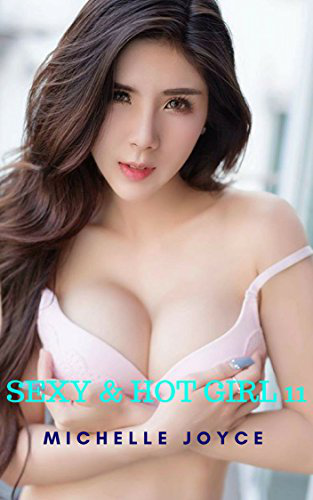

In [37]:
img6['image'].to_numpy()[0]

In [38]:
model.predict_topk(img6['image'])

id,class,probability
0,porn,0.8808616828095922
0,sexy,0.09146356793436534
0,neutral,0.02431628495778949


### Check the images in False Predictions

In [39]:
false_predictions = test_data[test_data['label'] != predictions]
false_predictions

path,deep_features,label
/home/turi/turi/NSFW/data/images/drawings/0FKQ ...,"[0.09784788638353348,0.0, 0.43259939551353 ...",drawings
/home/turi/turi/NSFW/data/images/drawings/0d1x ...,"[0.2004232406616211, 0.0,1.0864325761795044, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/0esc ...,"[0.6870428323745728, 0.0,0.5722228288650513, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/0h4a ...,"[0.09763291478157043,0.0, 0.5367065072059631, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/0o7r ...,"[0.4838216304779053, 0.0,0.9137886762619019, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/10ta ...,"[0.3532995581626892, 0.0,0.5558958053588867, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/11wy ...,"[0.37967821955680847,0.0, 1.057923674583435, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/1abp ...,"[0.32418328523635864,0.0, 1.700053334236145, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/1bao ...,"[0.4140940308570862, 0.0,1.1585406064987183, ...",drawings
/home/turi/turi/NSFW/data/images/drawings/1cdd ...,"[0.16127803921699524,0.0, 1.6587858200073242, ...",drawings


In [40]:
import random

In [41]:
from PIL import Image

In [42]:
i = random.randint(0, len(false_predictions)-1)
while false_predictions[i]['label'] in ['porn', 'hentai']:
    i = random.randint(0, len(false_predictions)-1)    
print(false_predictions[i]['label'])
model.predict_topk(false_predictions[i]['deep_features'])

neutral


id,class,probability
0,neutral,0.4828941429737078
0,sexy,0.48804963439026533
0,porn,0.029033614230801755


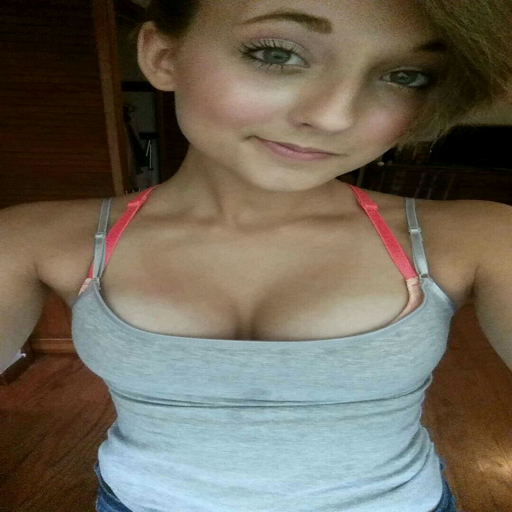

In [43]:
img = Image.open(false_predictions[i]['path'])
img.resize((512, 512))

###  Script

##### modeling

```python

# -*- coding: utf-8 -*-

"""
Data loading and model learning with pre-processing
If needed more detail, see the document which is ipynb file.
"""
import argparse

parser = argparse.ArgumentParser(description='파일 폴더, 모델 구조를 지정해주세요.')

parser.add_argument('--directory', '-d', default='images', help='클래스별 이미지를 포함한 상위 폴더 ex. images/class/image_01.jpg --> images')
parser.add_argument('--model', '-m', default='resnet-50', help="사용할 모델('resnet-50' or 'squeezenet_v1.1')")
parser.add_argument('--file', '-f', default='NSFWClassification.model', help='저장할 모델명 ex. file01.model')
args = parser.parse_args()

import turicreate as tc

# Configure Use of GPU
tc.config.set_num_gpus(1)

# Data loading
data = tc.image_analysis.load_images(args.directory, with_path=True)

# Pre-processing
data['deep_features'] = tc.image_analysis.get_deep_features(data['image'], model_name=args.model)
del data['image']
data['label'] = data['path'].apply(lambda x : x.split('/')[-2])

train_data, test_data = data.random_split(0.9)
model = tc.image_classifier.create(train_data, feature='deep_features', target='label', max_iterations=100, model=args.model)

model.save(args.file)
```

##### inference

```python

# -*- coding: utf-8 -*-

"""
Image Inference using input data and model
Input data can be one(file or url) or many(directory)
"""
import argparse
parser = argparse.ArgumentParser(description='예측을 위한 이미지와 모델을 입력해주세요.')

parser.add_argument('--data', '-d', help='파일, url 또는 파일이 포함된 폴더')
parser.add_argument('--model', '-m', default='resnet', help="학습한 모델('resnet' or 'squeezenet')")
parser.add_argument('--file', '-f', default='result.txt', help='저장할 파일명 ex. file01.txt')
args = parser.parse_args()

import turicreate as tc

# Model loading
if args.model == 'resnet':
    model = tc.load_model('resnet.model')
elif args.model == 'squeezenet':
    model = tc.load_model('squeezenet.model')
else:
    raise Exception('No model named {}'.format(args.model))

# Data pre-processing
data = tc.image_analysis.load_images(args.data)
data_features = tc.image_analysis.get_deep_features(data['image'], model_name=model.model)
del data['image']

# Output model prediction with probability
result = model.predict_topk(data_features)
result.print_rows(num_rows=len(result))
result = result.to_dataframe()
result.to_csv(args.file, index=False)
```

### Test and Time Chcek
- Total time: 3h 21min (It can be varied)

In [44]:
%%time
import turicreate as tc

tc.config.set_num_gpus(1)

data = tc.image_analysis.load_images('images', with_path=True)
data['deep_features'] = tc.image_analysis.get_deep_features(data['image'], model_name="resnet-50", batch_size=128)
del data['image']
data['label'] = data['path'].apply(lambda x : x.split('/')[-2])

train_data,test_data = data.random_split(0.9)
model = tc.image_classifier.create(train_data, feature='deep_features', target='label', max_iterations=100)

# model.save('NSFWClassification.model')

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/0HbDMHe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/0M3gKuG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/0iKs4sG.jpg

Read 258 images in 5.01479 secs	speed: 51.4478 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/118uGVZ.jpg

Read 497 images in 10.0178 secs	speed: 47.771 file/sec

Read 746 images in 15.0284 secs	speed: 49.6947 file/sec

Read 971 images in 20.076 secs	speed: 44.5755 file/sec

Read 1188 images in 25.1897 secs	speed: 42.4357 file/sec

Read 1371 images in 30.2021 secs	speed: 36.5088 file/sec

Read 1572 images in 35.2061 secs	speed: 40.1686 file/sec

Read 1776 images in 40.2087 secs	speed: 40.7783 file/sec

Read 1914 images in 45.2333 secs	speed: 27.4652 file/sec

Read 2064 images in 50.3051 secs	speed: 29.5751 file/sec

Read 2096 images in 63.5163 secs	speed: 2.42218 file/sec

Read 2104 images in 74.8488 secs	speed: 0.705937 file/sec

Read 2112 images in 83.6258 secs	speed: 0.911476 file/sec

Read 2120 images in 98.9326 secs	speed: 0.522643 file/sec

Read 2128 images in 137.996 secs	speed: 0.204797 file/sec

Read 2136 images in 168.753 secs	speed: 0.260098 file/sec

Read 2144 images in 175.368 secs	speed: 1.20946 file/sec

Read 2152 images in 206.853 secs	speed: 0.254085 file/sec

Read 2160 images in 227.31 secs	speed: 0.391075 file/sec

Read 2168 images in 243.023 secs	speed: 0.509128 file/sec

Read 2176 images in 249.254 secs	speed: 1.28394 file/sec

Read 2184 images in 260.294 secs	speed: 0.724653 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/1xFWdUq.jpg

Read 2426 images in 265.319 secs	speed: 48.1544 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/2iYerai.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/2vVMgpQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/3AoYCDE.jpg

Read 2695 images in 270.336 secs	speed: 53.6181 file/sec

Read 2880 images in 275.499 secs	speed: 35.8305 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/48Zk5Im.jpg

Read 2959 images in 280.633 secs	speed: 15.389 file/sec

Read 2981 images in 285.695 secs	speed: 4.34572 file/sec

Read 3002 images in 291.327 secs	speed: 3.72908 file/sec

Read 3023 images in 296.546 secs	speed: 4.02343 file/sec

Read 3051 images in 301.924 secs	speed: 5.20607 file/sec

Read 3076 images in 307.025 secs	speed: 4.90164 file/sec

Read 3103 images in 312.051 secs	speed: 5.37196 file/sec

Read 3129 images in 317.31 secs	speed: 4.94348 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/5Iuk6VS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/5bTbndg.jpg

Read 3397 images in 322.316 secs	speed: 53.5415 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/6Ly1dKY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/6ql0KID.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/6v615Kb.jpg

Read 3662 images in 327.338 secs	speed: 52.7688 file/sec

Read 3943 images in 332.351 secs	speed: 56.0486 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/8F5LNy1.jpg

Read 4215 images in 337.368 secs	speed: 54.2201 file/sec

Read 4499 images in 342.395 secs	speed: 56.4967 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/AkgGNcr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/AnxR317.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Aqz2OvL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/AwnmN2T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/B75y4ac.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/BCOmNX5.jpg

Read 4775 images in 347.414 secs	speed: 54.9914 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/C7GgIuL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/CJiUCrV.jpg

Read 4849 images in 352.595 secs	speed: 14.2829 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/CdWEuyA.jpg

Read 4870 images in 357.596 secs	speed: 4.19887 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Dq44yxP.jpg

Read 5120 images in 362.598 secs	speed: 49.984 file/sec

Read 5400 images in 367.616 secs	speed: 55.7924 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/HELEsR5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/HTVpozn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/HoQqKl0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Hso2RRH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/IG3voim.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/IXkbVn0.jpg

Read 5661 images in 372.635 secs	speed: 52.0042 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/J8C1cpM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/JKdGnhz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/JsCaEnA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/KIe0sn7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Ke8EqFf.jpg

Read 5946 images in 377.648 secs	speed: 56.8477 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/LKgz8QQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/M2tHxLD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/MzUgJLd.jpg

Read 6214 images in 382.658 secs	speed: 53.4943 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/NJ1szHQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/NhbDQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/ODVxPDA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/OaUvBo3.jpg

Read 6464 images in 387.677 secs	speed: 49.8118 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/P6HKpAo.jpg

Read 6515 images in 392.703 secs	speed: 10.1472 file/sec

Read 6532 images in 397.894 secs	speed: 3.27517 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Q0wqNGZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Q63AHPL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/QnSdt3H.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Qtj7tZH.jpg

Read 6799 images in 402.897 secs	speed: 53.3625 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/S8F22x1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/SDpwgOz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/SeeId3M.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/TlNeWeW.jpg

Read 7077 images in 407.912 secs	speed: 55.4333 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/UMldv8f.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/UiSKkHE.jpg

Read 7343 images in 412.914 secs	speed: 53.1862 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/WuP4UYR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/XEvARxk.jpg

Read 7614 images in 417.916 secs	speed: 54.1788 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/XgOWqIM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/XrbwUcD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Y6N4PBt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/YStJpL8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/YYBpUqZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/YwlYPqy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/Z2xuI9R.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/ZCwvkTN.jpg

Read 7855 images in 422.916 secs	speed: 48.1931 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/ZWZ0DUx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/a1oEx3M.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/aK7hQr5.jpg

Read 8136 images in 427.936 secs	speed: 55.9749 file/sec

Read 8197 images in 433.103 secs	speed: 11.8057 file/sec

Read 8219 images in 438.116 secs	speed: 4.38909 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/brp7l3A.jpg

Read 8430 images in 443.125 secs	speed: 42.1234 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/c23cwsf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/cbmbzCO.jpg

Read 8700 images in 448.133 secs	speed: 53.9078 file/sec

Read 8970 images in 453.145 secs	speed: 53.8771 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/eDXL5TI.jpg

Read 9231 images in 458.152 secs	speed: 52.1279 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/fB929fH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/fonUpoe.jpg

Read 9490 images in 463.154 secs	speed: 51.7766 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/fw0EcAj.jpg

Read 9756 images in 468.156 secs	speed: 53.1798 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/gyL4daT.jpg

Read 9867 images in 473.309 secs	speed: 21.5423 file/sec

Read 9890 images in 478.485 secs	speed: 4.44297 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/hBO4wUO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/hXqzoYi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/hiEYKGl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/hnOGmOB.jpg

Read 10090 images in 483.496 secs	speed: 39.9149 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/iboB6Tu.jpg

Read 10335 images in 488.507 secs	speed: 48.8889 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/jhSodN3.jpg

Read 10580 images in 493.511 secs	speed: 48.9618 file/sec

Read 10847 images in 498.511 secs	speed: 53.3992 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/lLikcWG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/lR4un33.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/la0ryFk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/lfpeoIA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/lneHflE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/loS9eLc.jpg

Read 11103 images in 503.521 secs	speed: 51.0992 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/m5qCj6Q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/mFgemVM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/mlyvtO0.jpg

Read 11365 images in 508.546 secs	speed: 52.1404 file/sec

Read 11478 images in 513.599 secs	speed: 22.3612 file/sec

Read 11501 images in 518.758 secs	speed: 4.45818 file/sec

Read 11708 images in 523.761 secs	speed: 41.3765 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/oZsBnVS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/oo02T5X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/orPK1jE.jpg

Read 11960 images in 528.783 secs	speed: 50.1843 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/pXzTzu6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/pkwVmYI.jpg

Read 12234 images in 533.8 secs	speed: 54.6108 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/qlyXMz8.jpg

Read 12490 images in 538.825 secs	speed: 50.9489 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/qzKK6dC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/rSTRmqr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/rTQaEYh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/rhzTYbQ.jpg

Read 12744 images in 543.825 secs	speed: 50.7932 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/s56te8x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/sQn8OgM.jpg

Read 12997 images in 548.87 secs	speed: 50.1511 file/sec

Read 13101 images in 553.988 secs	speed: 20.3203 file/sec

Read 13121 images in 559.457 secs	speed: 3.65679 file/sec

Read 13344 images in 564.481 secs	speed: 44.3945 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/txRZjpB.jpg

Read 13612 images in 569.493 secs	speed: 53.4675 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/umGH4bC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/uonSP9z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/vEjekdN.jpg

Read 13872 images in 574.501 secs	speed: 51.9177 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/viCHclT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/vshRDZM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/vxO5Ugm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/wWNbDgF.jpg

Read 14120 images in 579.525 secs	speed: 49.3598 file/sec

Read 14376 images in 584.558 secs	speed: 50.8673 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/xBzkqUg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/xl8AAWm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/xwfOFK0.jpg

Read 14631 images in 589.571 secs	speed: 50.8631 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/yCi4rbx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/ydSgims.jpg

Read 14734 images in 594.658 secs	speed: 20.2511 file/sec

Read 14752 images in 599.658 secs	speed: 3.59955 file/sec

Read 14907 images in 604.659 secs	speed: 30.9979 file/sec

Read 15160 images in 609.675 secs	speed: 50.4348 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/drawings/zuH1zNJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/0Qx0NkV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/0eefmhB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/0nIWFak.jpg

Read 15428 images in 614.681 secs	speed: 53.5363 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/1MtgzQJ.jpg

Read 15694 images in 619.697 secs	speed: 53.0263 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/1mcGX09.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/204edb548edfc77137088bbbda990098.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/20887094.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/20890934.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/22_bfjpaclyo3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/2Sh9HvwRJ3s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/3Di4Y7j.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/3ngG9De.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/3v8d7cm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/49HVSHC.jpg

Read 16088 images in 624.702 secs	speed: 78.7268 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/5sUSVMp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/66101648_p0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/6LpjWqI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/6gagDs3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/6tpNVTK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/7Vrsl9V.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/8nE6Sja.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/AP4Kr4e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/AVlnI9z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/AxD82YE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/C30p5wA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/CL1ozkq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/CM8XxKd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/CiFoOVC.jpg

Read 16620 images in 629.708 secs	speed: 106.262 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/DGqF00a.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/DLPwrsP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Dif3nAk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Dinner.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/DoeNtUa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/EsNNTwU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/FwIAWw9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/G51e7CC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/GpaNxK9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/H485lQ7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/H4NpNkJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/HsZDHOM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/I6JJJtA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/IMnW65G.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/J5l3SFf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/KpPuthS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/LRGWPZf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/MGL4rVJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/MaF5cVt.jpg

Read 16868 images in 634.739 secs	speed: 49.2933 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Nry1xRN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/OUOo9nX.jpg

Read 16892 images in 639.889 secs	speed: 4.66066 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/OwWNxAM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/PLEI4Lc.jpg

Read 16916 images in 645.789 secs	speed: 4.06769 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/PkQsYQ7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Pokey-gals.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/PtE01u1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/QETkF9W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/QHxQDXi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Qih1oAq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/RFPML5q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/RGJhE6g.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/RfbcQSd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/SSfcwKI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/TDjGdtf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Tb1vWfg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/TjdFkDp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/UNasH3O.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/VNPOtkF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/VzgpDFK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/W35VrAe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/WF6y9SI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/WikupzJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/X0aSctl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/XjlAtRF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/XttRXwP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/Xze3tF3EZN0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/YMbF3f8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/YTwyiCb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/ZORynEi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/a5vFEdM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/a9WHcbz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/aUbuuqD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/ad18248e0c0f79027aa996c2e8944241.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/adgrgdZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/bTjt6YA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/bw201se.jpg

Read 17288 images in 650.801 secs	speed: 74.2176 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/bz2DPde.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/cIbqwb8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/cS6VPnU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/cyYEXG2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/dQFByZ6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/dYef2cT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/dragonball-z-hentai-doujinshi-100312.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/fKLe9Jd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/gEOJAVH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/gvwlyhp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/hh6gXAmy-Uk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/iF9FP7n.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/iqHOOCh.jpg

Read 17890 images in 655.862 secs	speed: 118.95 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/jEgDdfg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/kIXiPmp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/kRXS3iP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/khFuqf9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/khLLvrF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/kuNu6Z0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/l1avowQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/lXQTDkY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/m-ZRsVnv7jg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/nRa87pX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/nregM1lUNcP36Ub-mfCXzELjzyehQamSu4IKc1tv2-U.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/o4d69S0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/obl6qnarz4p21.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/oo4Ilrg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/ovwi8iV.jpg

Read 18412 images in 660.887 secs	speed: 103.886 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/qrBOYWK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/qx5RQ33.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/r0nRfWF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/sDSYpZt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/scAlOc7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/scKDmPk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/so0Hxwd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/tABp0ic.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/tWEGmSn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/tf2tWBQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/the-hunger-for-sperm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/trINZcd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/uGIG45t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/uXz3Ihz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/uu07NHm.jpg

Read 18940 images in 665.897 secs	speed: 105.395 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/vJKzmCt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/www.hiqqu_.xxx-aca5cf917bb298d0b89754088535df4a4cffb0ca.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/xdxlR6n.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/hentai/zhMdvd0.jpg

Read 19404 images in 670.928 secs	speed: 92.2246 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/0TghkWR.jpg

Read 19763 images in 675.931 secs	speed: 71.751 file/sec

Read 19885 images in 681.078 secs	speed: 23.7044 file/sec

Read 19897 images in 686.47 secs	speed: 2.22544 file/sec

Read 19968 images in 691.475 secs	speed: 14.1878 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/0lxPt24.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/0r5Dbyn.jpg

Read 20300 images in 696.491 secs	speed: 66.1844 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/18FkhG7.jpg

Read 20591 images in 701.502 secs	speed: 58.0709 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/1eu82un.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/1gxnA8J.jpg

Read 20896 images in 706.524 secs	speed: 60.7297 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/1zg9d2s.jpg

Read 21149 images in 711.528 secs	speed: 50.5631 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/2ONdZu8.jpg

Read 21442 images in 716.54 secs	speed: 58.4535 file/sec

Read 21770 images in 721.543 secs	speed: 65.561 file/sec

Read 21789 images in 726.786 secs	speed: 3.624 file/sec

Read 21807 images in 731.996 secs	speed: 3.45503 file/sec

Read 21830 images in 737.069 secs	speed: 4.5338 file/sec

Read 22035 images in 742.104 secs	speed: 40.7156 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/34SnC1x.jpg

Read 22355 images in 747.108 secs	speed: 63.9481 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/3fecoQA.jpg

Read 22697 images in 752.112 secs	speed: 68.3405 file/sec

Read 22985 images in 757.113 secs	speed: 57.5928 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/4MpYR98.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/4VsKUkB.jpg

Read 23311 images in 762.113 secs	speed: 65.1988 file/sec

Read 23635 images in 767.127 secs	speed: 64.6267 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/54817_0_1008x803.jpg

Read 23760 images in 772.157 secs	speed: 24.8462 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/54hPKgp.jpg

Read 23776 images in 777.537 secs	speed: 2.97434 file/sec

Read 23792 images in 782.543 secs	speed: 3.19575 file/sec

Read 24039 images in 787.55 secs	speed: 49.3397 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/5iRbH4R.jpg

Read 24246 images in 792.554 secs	speed: 41.366 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/5owrbG5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/5umyayc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/60868.jpg

Read 24598 images in 797.565 secs	speed: 70.2472 file/sec

Unsupported colorspace format. Currently, only RGB and Grayscale are supported.	 file: /home/turi/turi/NSFW/data/images/neutral/6802649937_55503d4ab8_o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/6RR0jLT.jpg

Read 24904 images in 802.577 secs	speed: 61.0429 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/6n71vK1.jpeg

Read 25192 images in 807.588 secs	speed: 57.4838 file/sec

Read 25514 images in 812.612 secs	speed: 64.0873 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/7QZ6dhN.jpg

Read 25619 images in 818.343 secs	speed: 18.3206 file/sec

Read 25649 images in 823.529 secs	speed: 5.78514 file/sec

Read 25753 images in 828.532 secs	speed: 20.7888 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/7kwgc4U.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/7t3dt9S.jpg

Read 26074 images in 833.587 secs	speed: 63.4906 file/sec

Read 26302 images in 838.591 secs	speed: 45.569 file/sec

Read 26554 images in 843.631 secs	speed: 50.0014 file/sec

Read 26799 images in 848.641 secs	speed: 48.8978 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/8wBLqxv.jpg

Read 27052 images in 853.655 secs	speed: 50.4644 file/sec

Read 27169 images in 858.739 secs	speed: 23.0095 file/sec

Read 27195 images in 863.913 secs	speed: 5.02575 file/sec

Read 27215 images in 869.178 secs	speed: 3.79872 file/sec

Read 27255 images in 874.326 secs	speed: 7.76905 file/sec

Read 27311 images in 879.338 secs	speed: 11.1735 file/sec

Read 27470 images in 884.352 secs	speed: 31.7108 file/sec

Read 27800 images in 889.39 secs	speed: 65.5028 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/AUCn6mi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/AX8FrHo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/AjDDkDJ.jpeg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/AzM7Mf9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/B04BRdM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/BQT2VgD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/BVRTz.jpg

Read 28112 images in 894.402 secs	speed: 62.258 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/BsHY5EJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/CD4xR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/CGTJC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/CKzSTcL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/CMcph4e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/CfLVqct.jpg

Read 28328 images in 899.436 secs	speed: 42.9032 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/DkAsoN0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Dlkmhfh.jpg

Read 28529 images in 904.546 secs	speed: 39.34 file/sec

Read 28550 images in 909.594 secs	speed: 4.15991 file/sec

Read 28643 images in 914.61 secs	speed: 18.5379 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/F2uCnPp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/FEt8WMD.jpg

Read 28894 images in 919.625 secs	speed: 50.0499 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/GGsmKFw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/GwlSknU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/GxYH0zR.jpg

Read 29159 images in 924.631 secs	speed: 52.9455 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/HYMotfn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/HwKMBIN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/IJzhk7Q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/IpTQ2gt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/IpjO7dB.jpg

Read 29439 images in 929.642 secs	speed: 55.8774 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/JToX7Iz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/JhEJovd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Jyd6FHk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/KGdBcfR.jpg

Read 29726 images in 934.658 secs	speed: 57.2167 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/KZRIhDIh.jpg

Read 30005 images in 939.673 secs	speed: 55.6294 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/M36iKWo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/M5q9AmS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/M7HrfwT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/MNgQFn3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/MTirX6D.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Ml4Rh50.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Monkey-Riding-Bull-Yes-Indeed_500x500.jpg

Read 30214 images in 945.242 secs	speed: 37.532 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/MymdqfA.jpg

Read 30239 images in 950.622 secs	speed: 4.64611 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/NfJNFUI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/NsM1mnu.jpg

Read 30366 images in 955.657 secs	speed: 25.2234 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/OA3dAuv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/OEI2p2N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/OJO9v6t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/OVNMdbu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/OhMjofA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Os8FESE.jpg

Read 30584 images in 960.693 secs	speed: 43.2923 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/PLczS4x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/PkqD6xv.jpg

Read 30805 images in 965.724 secs	speed: 43.9307 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Qfzwkie.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/RBxf21H.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/RIopO6i.jpg

Read 31071 images in 970.724 secs	speed: 53.1927 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/RhDHd49.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/RuxpbRf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/RvgGhMk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/S0aMs9x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/SnR5svP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/SputaAg.jpg

Read 31312 images in 975.727 secs	speed: 48.1724 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/SycIP0c.jpg

Read 31558 images in 980.748 secs	speed: 48.9974 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/UYciAKC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Ufud9D8.jpg

Read 31757 images in 985.827 secs	speed: 39.1794 file/sec

Read 31783 images in 990.978 secs	speed: 5.04794 file/sec

Read 31939 images in 995.988 secs	speed: 31.1361 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/WIyoPLz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/Wdh03Pm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/WzRhcaV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/X1WftuW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/XOpONzL.jpg

Read 32201 images in 1000.99 secs	speed: 52.3404 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/YRQpE97.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/YYpD4bO.jpg

Read 32483 images in 1006.02 secs	speed: 56.0737 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/ZvTyjOu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/ZwuHs3R.jpg

Read 32811 images in 1011.02 secs	speed: 65.5815 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/aFNq8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/adarQpi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/aiz6wyX.jpg

Read 33154 images in 1016.05 secs	speed: 68.201 file/sec

Invalid PNG file	 file: /home/turi/turi/NSFW/data/images/neutral/an4zx.jpg.png

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/aqgEMsJ.jpg

Read 33464 images in 1021.06 secs	speed: 61.9163 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/b63cJHb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/b7mYDVH.jpg

Read 33682 images in 1026.09 secs	speed: 43.3465 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/bPnWl8T.jpg

Read 33714 images in 1031.27 secs	speed: 6.1721 file/sec

Read 33740 images in 1036.57 secs	speed: 4.91188 file/sec

Read 34074 images in 1041.57 secs	speed: 66.7622 file/sec

Read 34484 images in 1046.59 secs	speed: 81.6082 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/cHVZu5X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/cJP1aJC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/cRM4RCG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/cid1NJt.jpg

Read 34790 images in 1051.59 secs	speed: 61.1972 file/sec

Read 35131 images in 1056.61 secs	speed: 67.9637 file/sec

Unsupported colorspace format. Currently, only RGB and Grayscale are supported.	 file: /home/turi/turi/NSFW/data/images/neutral/d7o69u4axhc31.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/dJZmy7v.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/dPVGI.jpg

Read 35473 images in 1061.67 secs	speed: 67.5724 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/df113sj.jpg

Read 35854 images in 1066.68 secs	speed: 76.0585 file/sec

Read 35954 images in 1071.71 secs	speed: 19.8935 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/e0cUo4D.jpg

Read 35978 images in 1076.98 secs	speed: 4.55627 file/sec

Read 35996 images in 1082.12 secs	speed: 3.50058 file/sec

Read 36222 images in 1087.19 secs	speed: 44.5895 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/enhDnTM.jpg

Read 36624 images in 1092.21 secs	speed: 80.1027 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/f3QDYGa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/fFC6djg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/fGUFw1R.jpg

Read 37012 images in 1097.21 secs	speed: 77.5983 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/fTskvDa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/fa5Pst5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/fodGaKU.jpg

Read 37369 images in 1102.22 secs	speed: 71.1748 file/sec

Read 37758 images in 1107.25 secs	speed: 77.2942 file/sec

Read 38156 images in 1112.3 secs	speed: 78.8643 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/gymIVwY.jpg

Read 38413 images in 1117.42 secs	speed: 50.2068 file/sec

Read 38431 images in 1122.63 secs	speed: 3.45422 file/sec

Read 38454 images in 1127.67 secs	speed: 4.56621 file/sec

Read 38593 images in 1132.79 secs	speed: 27.151 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/hH6h1nX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/hPWV0Vh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/haxyNxp.jpg

Read 38911 images in 1137.79 secs	speed: 63.505 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/hss47eK.jpg

Read 39295 images in 1142.8 secs	speed: 76.7628 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/i9w0Ehj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/iAyDkDZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/iMabcTe.jpg

Read 39660 images in 1147.8 secs	speed: 72.9483 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/iuA8Z96.jpg

Read 40023 images in 1152.8 secs	speed: 72.5646 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/iw1100o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/j1sh8lF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/jPbOJDb.jpg

Read 40417 images in 1157.89 secs	speed: 77.4659 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/jam45bi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/jkpjQGb.jpg

Read 40703 images in 1164.13 secs	speed: 45.8136 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/johnny_depp_and_tim_burton.jpg

Read 40725 images in 1169.17 secs	speed: 4.36785 file/sec

Read 40754 images in 1174.53 secs	speed: 5.41269 file/sec

Read 40870 images in 1179.55 secs	speed: 23.1032 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/kApNzBF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/kJIlDzw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/kStvMNt.jpg

Read 41270 images in 1184.55 secs	speed: 79.9914 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/ksUwkhc.jpg

Read 41667 images in 1189.71 secs	speed: 76.9563 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/l6CIQaS.jpg

Read 42037 images in 1194.72 secs	speed: 73.8632 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/lk9wdklq6dz.jpg

Read 42412 images in 1199.72 secs	speed: 74.9216 file/sec

Read 42815 images in 1204.72 secs	speed: 80.5691 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/mJFr9Zj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/mWUXBP2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/mWf8Ze6.jpg

Read 43133 images in 1210.15 secs	speed: 58.607 file/sec

Read 43159 images in 1215.4 secs	speed: 4.95024 file/sec

Read 43184 images in 1220.54 secs	speed: 4.86092 file/sec

Read 43209 images in 1225.76 secs	speed: 4.79661 file/sec

Read 43551 images in 1230.77 secs	speed: 68.2418 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/ndrvUO1.jpg

Read 43942 images in 1235.77 secs	speed: 78.1704 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/nov09wallpaper-4_1600.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/nvdcfch.jpg

Read 44328 images in 1240.77 secs	speed: 77.1806 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/oErHsI0.jpg

Read 44714 images in 1245.79 secs	speed: 76.9512 file/sec

Read 45130 images in 1250.79 secs	speed: 83.1816 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/pNAdJkQ.jpg

Read 45527 images in 1255.79 secs	speed: 79.3777 file/sec

Read 45603 images in 1261.09 secs	speed: 14.3273 file/sec

Read 45632 images in 1266.28 secs	speed: 5.59652 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/plydIww.jpg

Read 45664 images in 1271.37 secs	speed: 6.28335 file/sec

Read 45837 images in 1276.37 secs	speed: 34.5676 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/pztT3Bd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/qPyARnA.jpg

Read 46244 images in 1281.39 secs	speed: 81.1302 file/sec

Read 46636 images in 1286.4 secs	speed: 78.1798 file/sec

Read 46980 images in 1291.41 secs	speed: 68.7215 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/rCNduyR.jpg

Read 47345 images in 1296.42 secs	speed: 72.8476 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/rytou18.jpg

Read 47709 images in 1301.42 secs	speed: 72.7968 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/sFz2hWi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/sJZ2HYt.jpg

Read 47937 images in 1306.5 secs	speed: 44.9124 file/sec

Read 47959 images in 1311.98 secs	speed: 4.01341 file/sec

Read 47982 images in 1317.63 secs	speed: 4.07313 file/sec

Read 48163 images in 1322.64 secs	speed: 36.1201 file/sec

Read 48481 images in 1327.65 secs	speed: 63.4499 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/tE2a38t.jpg

Read 48872 images in 1332.66 secs	speed: 78.0944 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/ttLnska.jpg

Read 49283 images in 1337.68 secs	speed: 81.8565 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/uGyDW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/uQfNyQl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/uWXDXBq.jpg

Read 49676 images in 1342.68 secs	speed: 78.5947 file/sec

Read 50101 images in 1347.68 secs	speed: 84.8776 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/v06J9BJ.jpg

Read 50411 images in 1352.8 secs	speed: 60.5603 file/sec

Read 50434 images in 1358.09 secs	speed: 4.34737 file/sec

Read 50459 images in 1363.22 secs	speed: 4.87498 file/sec

Read 50478 images in 1370.46 secs	speed: 2.62364 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/vbFpmuY.jpg

Read 50571 images in 1375.48 secs	speed: 18.5444 file/sec

Read 50613 images in 1380.96 secs	speed: 7.66665 file/sec

Read 50647 images in 1385.97 secs	speed: 6.77605 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/vldnauA.jpg

Read 50902 images in 1390.98 secs	speed: 50.9522 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/vumuWpa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/vuyZQcS.jpg

Read 50999 images in 1395.98 secs	speed: 19.3841 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/w.php?id=234200712145.jpg

Read 51140 images in 1400.99 secs	speed: 28.1724 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/wetkoala.jpg

Read 51508 images in 1405.99 secs	speed: 73.5751 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/wjL7hFT.jpg

Read 51900 images in 1411.03 secs	speed: 77.8368 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/xYOWEzf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/xZKs5la.jpg

Read 52224 images in 1416.05 secs	speed: 64.4588 file/sec

Read 52640 images in 1421.06 secs	speed: 83.0942 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/yZjSQgV.jpg

Read 53043 images in 1426.06 secs	speed: 80.5911 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/ymt6ZDA.jpg

Read 53323 images in 1431.06 secs	speed: 55.9435 file/sec

Read 53400 images in 1436.39 secs	speed: 14.4558 file/sec

Read 53417 images in 1441.44 secs	speed: 3.36766 file/sec

Read 53444 images in 1446.49 secs	speed: 5.34546 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/z6E322S.jpg

Read 53674 images in 1451.5 secs	speed: 45.9523 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/zebralionhug.jpg

Read 53927 images in 1456.5 secs	speed: 50.5252 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/neutral/zwuGIF4.jpg

Read 54326 images in 1461.51 secs	speed: 79.6882 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/0GDAhIQ.jpg

Read 55212 images in 1466.51 secs	speed: 177.024 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/1veUaoA.jpg

Read 56484 images in 1471.52 secs	speed: 254.318 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/22SVfhJ.jpg

Read 57540 images in 1476.52 secs	speed: 211.182 file/sec

Read 59047 images in 1481.52 secs	speed: 301.008 file/sec

Read 59598 images in 1486.57 secs	speed: 109.121 file/sec

Read 59637 images in 1491.67 secs	speed: 7.64392 file/sec

Read 59674 images in 1496.78 secs	speed: 7.25394 file/sec

Read 59711 images in 1501.78 secs	speed: 7.39554 file/sec

Read 60349 images in 1506.79 secs	speed: 127.385 file/sec

Read 60997 images in 1511.79 secs	speed: 129.484 file/sec

Read 61727 images in 1516.79 secs	speed: 145.905 file/sec

Read 62412 images in 1521.8 secs	speed: 136.929 file/sec

Read 63038 images in 1526.8 secs	speed: 125.187 file/sec

Read 63657 images in 1531.81 secs	speed: 123.594 file/sec

Read 63777 images in 1537 secs	speed: 23.1198 file/sec

Read 63801 images in 1542.33 secs	speed: 4.5021 file/sec

Read 64011 images in 1547.33 secs	speed: 41.9544 file/sec

Read 64619 images in 1552.34 secs	speed: 121.5 file/sec

Read 65125 images in 1557.34 secs	speed: 101.083 file/sec

Read 65686 images in 1562.35 secs	speed: 112.042 file/sec

Read 66312 images in 1567.36 secs	speed: 124.975 file/sec

Read 66896 images in 1572.37 secs	speed: 116.587 file/sec

Read 67164 images in 1577.59 secs	speed: 51.3452 file/sec

Read 67193 images in 1582.66 secs	speed: 5.71488 file/sec

Read 67349 images in 1587.67 secs	speed: 31.1391 file/sec

Read 67943 images in 1592.68 secs	speed: 118.636 file/sec

Read 68504 images in 1597.68 secs	speed: 112.19 file/sec

Read 69147 images in 1602.68 secs	speed: 128.535 file/sec

Read 69777 images in 1607.69 secs	speed: 125.822 file/sec

Read 70396 images in 1612.69 secs	speed: 123.666 file/sec

Read 70977 images in 1617.71 secs	speed: 115.916 file/sec

Read 71002 images in 1622.87 secs	speed: 4.84497 file/sec

Read 71022 images in 1628.11 secs	speed: 3.81257 file/sec

Read 71042 images in 1633.14 secs	speed: 3.97804 file/sec

Read 71840 images in 1638.16 secs	speed: 158.914 file/sec

Read 72535 images in 1643.17 secs	speed: 138.829 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/2xAWWd8.jpg

Read 73276 images in 1648.52 secs	speed: 138.32 file/sec

Read 73313 images in 1653.57 secs	speed: 7.33118 file/sec

Read 73513 images in 1658.58 secs	speed: 39.9675 file/sec

Read 74379 images in 1663.58 secs	speed: 173.128 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/3152Dkx.jpg

Read 75128 images in 1668.58 secs	speed: 149.799 file/sec

Read 76172 images in 1673.58 secs	speed: 208.743 file/sec

Read 77199 images in 1678.58 secs	speed: 205.241 file/sec

Read 78321 images in 1683.58 secs	speed: 224.321 file/sec

Read 78839 images in 1688.79 secs	speed: 99.4919 file/sec

Read 78872 images in 1693.92 secs	speed: 6.43579 file/sec

Read 78900 images in 1698.94 secs	speed: 5.57662 file/sec

Read 78936 images in 1704.05 secs	speed: 7.03839 file/sec

Read 78972 images in 1709.25 secs	speed: 6.93498 file/sec

Read 79837 images in 1714.25 secs	speed: 172.966 file/sec

Read 80749 images in 1719.25 secs	speed: 182.39 file/sec

Read 81625 images in 1724.25 secs	speed: 175.169 file/sec

Read 82385 images in 1729.26 secs	speed: 151.706 file/sec

Read 82680 images in 1734.27 secs	speed: 58.8642 file/sec

Read 83012 images in 1739.27 secs	speed: 66.333 file/sec

Read 83127 images in 1744.28 secs	speed: 22.9773 file/sec

Read 83144 images in 1749.35 secs	speed: 3.34979 file/sec

Read 83162 images in 1754.53 secs	speed: 3.47498 file/sec

Read 83187 images in 1759.7 secs	speed: 4.83676 file/sec

Read 83220 images in 1764.77 secs	speed: 6.51766 file/sec

Read 83265 images in 1769.88 secs	speed: 8.80218 file/sec

Read 83312 images in 1774.99 secs	speed: 9.19216 file/sec

Read 83616 images in 1780 secs	speed: 60.7067 file/sec

Read 84309 images in 1785.01 secs	speed: 138.369 file/sec

Read 84872 images in 1790.01 secs	speed: 112.521 file/sec

Read 85291 images in 1795.03 secs	speed: 83.479 file/sec

Read 85312 images in 1800.25 secs	speed: 4.02492 file/sec

Read 85553 images in 1805.25 secs	speed: 48.1444 file/sec

Read 85973 images in 1810.25 secs	speed: 83.9864 file/sec

Read 86473 images in 1815.26 secs	speed: 99.8408 file/sec

Read 87165 images in 1820.26 secs	speed: 138.322 file/sec

Read 87793 images in 1825.27 secs	speed: 125.46 file/sec

Read 88501 images in 1830.28 secs	speed: 141.209 file/sec

Read 88774 images in 1835.45 secs	speed: 52.8358 file/sec

Read 88799 images in 1840.56 secs	speed: 4.88891 file/sec

Read 88951 images in 1845.57 secs	speed: 30.3561 file/sec

Read 89515 images in 1850.57 secs	speed: 112.795 file/sec

Read 89997 images in 1855.57 secs	speed: 96.3685 file/sec

Read 90488 images in 1860.58 secs	speed: 98.0471 file/sec

Read 91058 images in 1865.58 secs	speed: 113.991 file/sec

Read 91640 images in 1870.58 secs	speed: 116.356 file/sec

Read 92066 images in 1875.76 secs	speed: 82.2592 file/sec

Read 92092 images in 1881.01 secs	speed: 4.95657 file/sec

Read 92108 images in 1886.24 secs	speed: 3.05755 file/sec

Read 92568 images in 1891.25 secs	speed: 91.7722 file/sec

Read 92837 images in 1896.25 secs	speed: 53.7977 file/sec

Read 93306 images in 1901.26 secs	speed: 93.6397 file/sec

Read 93928 images in 1906.27 secs	speed: 124.227 file/sec

Read 94395 images in 1911.28 secs	speed: 93.2844 file/sec

Read 94938 images in 1916.28 secs	speed: 108.466 file/sec

Read 95097 images in 1921.4 secs	speed: 31.0599 file/sec

Read 95134 images in 1926.55 secs	speed: 7.18265 file/sec

Read 95170 images in 1931.58 secs	speed: 7.15567 file/sec

Read 95514 images in 1936.59 secs	speed: 68.7321 file/sec

Read 96056 images in 1941.6 secs	speed: 108.146 file/sec

Read 96568 images in 1946.6 secs	speed: 102.371 file/sec

Read 97006 images in 1951.68 secs	speed: 86.2816 file/sec

Read 97072 images in 1956.69 secs	speed: 13.1609 file/sec

Read 97449 images in 1961.7 secs	speed: 75.3388 file/sec

Read 97671 images in 1966.77 secs	speed: 43.7616 file/sec

Read 97707 images in 1971.84 secs	speed: 7.10078 file/sec

Read 97864 images in 1976.86 secs	speed: 31.2665 file/sec

Read 98190 images in 1981.87 secs	speed: 65.0203 file/sec

Read 98511 images in 1986.88 secs	speed: 64.1461 file/sec

Read 98816 images in 1991.89 secs	speed: 60.9008 file/sec

Read 99164 images in 1996.89 secs	speed: 69.4944 file/sec

Read 99599 images in 2001.91 secs	speed: 86.7976 file/sec

Read 99872 images in 2007 secs	speed: 53.5804 file/sec

Read 99891 images in 2012.26 secs	speed: 3.61153 file/sec

Read 99913 images in 2017.52 secs	speed: 4.1817 file/sec

Read 99987 images in 2022.53 secs	speed: 14.778 file/sec

Read 100314 images in 2027.54 secs	speed: 65.2848 file/sec

Read 100737 images in 2032.55 secs	speed: 84.5013 file/sec

Read 101160 images in 2037.55 secs	speed: 84.576 file/sec

Read 101621 images in 2042.55 secs	speed: 92.1906 file/sec

Read 102016 images in 2047.55 secs	speed: 78.9212 file/sec

Read 102367 images in 2052.81 secs	speed: 66.7657 file/sec

Read 102396 images in 2057.93 secs	speed: 5.66793 file/sec

Read 102421 images in 2062.93 secs	speed: 4.99518 file/sec

Read 102660 images in 2067.94 secs	speed: 47.6865 file/sec

Read 103175 images in 2072.95 secs	speed: 102.775 file/sec

Read 103630 images in 2077.97 secs	speed: 90.6112 file/sec

Read 104156 images in 2082.98 secs	speed: 105.189 file/sec

Read 104643 images in 2087.98 secs	speed: 97.376 file/sec

Read 105104 images in 2092.98 secs	speed: 92.1926 file/sec

Read 105491 images in 2098.07 secs	speed: 75.9339 file/sec

Read 105529 images in 2103.12 secs	speed: 7.52297 file/sec

Read 105614 images in 2108.13 secs	speed: 16.979 file/sec

Read 106150 images in 2113.13 secs	speed: 107.122 file/sec

Read 106562 images in 2118.15 secs	speed: 82.1355 file/sec

Read 106977 images in 2123.16 secs	speed: 82.8842 file/sec

Read 107542 images in 2128.16 secs	speed: 112.848 file/sec

Read 107979 images in 2133.17 secs	speed: 87.3107 file/sec

Read 108502 images in 2138.17 secs	speed: 104.59 file/sec

Read 108566 images in 2143.36 secs	speed: 12.3332 file/sec

Read 108605 images in 2148.43 secs	speed: 7.69287 file/sec

Read 109030 images in 2153.44 secs	speed: 84.8677 file/sec

Read 109542 images in 2158.44 secs	speed: 102.32 file/sec

Read 109900 images in 2163.44 secs	speed: 71.5947 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/5epy41F.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/6LG46vq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/6YXiaFg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/7FTcJ6y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/7htCQzZ.jpg

Read 110389 images in 2168.44 secs	speed: 97.7759 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/AWTzasQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/AnYMyHZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/AuVw4Lg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/ElMBqzn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/H7t9aOF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/HK2KxoF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/I1M0H65.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Ib6SRA1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Io76ZIl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Jenna-Haze-surrounded-by-cocks.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/JnJ8kmb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/JqWGzwh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Kqyp8PY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/R4f9z1l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/R6g7cK2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Rzv4555.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/SiX4hUQ.jpg

Read 110648 images in 2173.45 secs	speed: 51.7231 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/T1M8wCJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Tf6CVlP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/UCIvu3f.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Vjm5TvF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/X5O96bz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/Xh2nAlT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/YSM3DEk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/ZhkmnsT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/ZvkkqOG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/bkA8kNG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/cj8KV44.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/dcmIlm9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/eHD7s1l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/eKdiKfK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/eYJGevF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/fTfLKJP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/gKasOfs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/gcDMBV0.jpg

Read 110909 images in 2178.48 secs	speed: 51.9087 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/hDJXVYK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/iN0kGcj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/iohVHmj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/jk6W33Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/kbejgBs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/mGP4TOu.jpg

Read 111040 images in 2183.54 secs	speed: 25.8766 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/o9xU6vN.jpg

Read 111073 images in 2188.55 secs	speed: 6.58878 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/qpTMb3Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/t2GGEHw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/tumblr_n9mtswXZB91sjnouyo10_500.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/vnw51PS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/wE2HU25.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/wZHSGzO.jpg

Read 111265 images in 2193.55 secs	speed: 38.359 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/z0XemZG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/porn/z3JDfSn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/07MwDtJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/07iT24X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0A18yhC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0DNbpSt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0DS3G9a.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0DlMw5a.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0Dqm7Wz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0FkHvua.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0GDAhIQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0GnhTr9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0OiqarM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0QCoMz7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0UHLifu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0aFEqdT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0av2EDP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0bSyelc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0cget5W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0i3KvJn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0kCwwhf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0sFxlKI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0v1ZZOK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0vkFhbA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/0w5slxI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/10gJQBT.jpg

Read 111602 images in 2198.56 secs	speed: 67.2709 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/12O4VKa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/15eZnaa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/18cWcc5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/19NPi6z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/19jRjGF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1BPHc6R.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1CbGDxD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1D02x5r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1DLVuss.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1M3nQNl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1Mw95mg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1ONghI1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1RUeQ4e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1ZCY94M.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1dUKdJF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1hxRagx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1oq3HfR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1sRdPYY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1tSMFBm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1wHQgSX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/1zooodO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/20iB3fV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/26V1cI2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/26ukEL3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/294eZwk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2HDKK4b.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2M2GxwI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2MPO1wh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2QJdUUE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2QsgN2H.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2Vfr53V.jpg

Read 112004 images in 2203.56 secs	speed: 80.3948 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2dugVUR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2edWqEX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2fe7zrR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2hFjrNc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2k3CF8t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2mJX3Cj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2mVVZpi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2mxYyzc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2nQ0Jts.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2pFhvRg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2q7Urti.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2sHgja5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2sgFBYC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/2zQcMb2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/30ZS1eh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/30c4HVs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/30vlsns.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3Du0Baz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3Jwa8jz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3SWUXYj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3UcxU0i.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3UdUFpO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3UrORRY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3VOhRm2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3h0gEDP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3jnJRNE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3oCpzGg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3prSgR1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3rNAJxr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3rVpUYi.jpg

Read 112400 images in 2208.59 secs	speed: 78.8465 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3u2BDsv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3xC0zAG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3xys6Rh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/3yphOtr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/41TAaSk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/42qXYVJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/44VtSl9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/48UbWyg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4AnIHFt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4CjswIR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4GFpXB0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4HJXIl7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4LxXrlD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4PAeQcR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4Qhznx2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4StGad9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4UeSw3Z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4UljeeG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4W3VtUh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4XYltq3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4YiOsyY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4a7cZgL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4ai9odm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4cBoGAn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4cj9zN3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4eN6r2s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4eQ7TCx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4f1HEmo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4jISUPj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4nkniKZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4qVqFGK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4tQAtCs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4tR0pa7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4v4cxww.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4z94tQm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/4zbPZ4Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/512635.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/55w7WPr.jpg

Read 112741 images in 2213.6 secs	speed: 68.0258 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/56fkepj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/57A3VmU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/58O0H42.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5Fa54jb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5Pq53Sy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5Q74RB0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5Z7pAbp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5gGWRRe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5gbgM5Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5iNL0f8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5iUgADy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5jLPWyV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5m6cyTA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5rsACGA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5vIEvH7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5vcKjRL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5w2tudq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/5xB8Gwo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/62YDyyO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/64vLMYh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6864DC3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/69BppwU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6BLgCDK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6DOiIq3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6H0ODSO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6I7KqiC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6KEQomR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6OEGxq9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6P0SAqV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6VT6e7b.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6YlAHFM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6a2Lmbe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6bQw7VN.jpg

Read 113120 images in 2218.6 secs	speed: 75.7169 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6cfIOGK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6l5fGER.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6logFsF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6nt3QnI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6s529yK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6u5mK2i.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6v1Icpo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6w6uTbJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6wSxAXC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/6yYxV52.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/76RZ19O.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/77YIK5k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/78e3XnN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/79VVfyZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/79bciN3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7CIAU6F.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7Fyco00.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7HKTPSm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7ItTkSM.jpg

Read 113368 images in 2223.63 secs	speed: 49.3284 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7LhotKA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7MhVw75.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7RJAe8f.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7SBFf0r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7Sk9yeL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7T5cmyS.jpg

Read 113396 images in 2228.76 secs	speed: 5.45866 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7cemr8y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7iA4Oye.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7o5CJin.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7pGr6FB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7sGUnxM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7svIhku.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7tP0LGt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7uZsG7x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7vhnDIM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7xwYWJ5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/7zgjjun.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/818037315.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/82EMzk6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/82N7V3m.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/85UHGlC.jpg

Read 113626 images in 2233.77 secs	speed: 45.9194 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8FcvsWz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8IjBso7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8JuoQim.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8KrF2iF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8Nz8Vwz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8UPhdKP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8VBAlj3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8VqIGfU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8ZLOobE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8iVsQxz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8qZzdwu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8tKXDVK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8wjliVp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/8xA1v8N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9B0unFq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9DjF8fE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9F0N0m2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9GL9tCJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9Hz0GH9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9MNlCck.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9OTcHC1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9OlkF6I.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9RVjitx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9Rn5nkZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9SUHwCo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9UfkRhU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9X9FA3C.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9azuC7V.jpg

Read 113977 images in 2238.78 secs	speed: 70.0727 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9dg85xt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9hZ1n2t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9lPYtxM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9qElVbG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9rZSX4Z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9uCVvjK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/9yLMOsc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/A3JbFVx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/A6Q5SSE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/A8336pc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/APHOmyM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/APK3vRn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AUZZdG3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AX4ORVk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AZgvjbL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AdVwS9x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AdzboJy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ae7SI9M.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AezQy2N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AiYiEXk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AqurHz2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AsSmBnH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AsX9e3r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AvKEPWE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/AwgFL2M.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/B3ad3yr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/B5MFa0n.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BBSHtC2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BCT2I2r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BDEzSR2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BDNIGCO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BETK1aR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BGikBCN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BKyXGzN.jpg

Read 114337 images in 2243.78 secs	speed: 71.9756 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BSp13R9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BUO2ZtJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BVPbL0V.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BWhW5UG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BXNPvsY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Be9lDg2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Bf0MuOS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BgYb3gE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BgnIH3B.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BiZaJnW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BjzUJdv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BkM00E7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BlWnkBY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BoRReMs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BqLO4Bj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BrAG0mk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BtUOm9E.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/BywK2ts.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/C4AcKa2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/C4WjGOp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/C5wHPFQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/C6LSEZl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CIjAssx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CM16t7e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CMmRt8I.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CSgHQ9o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CT6Kosw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CXppesZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ch0sahL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ChehPzY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CiA8yHg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CmyOk4W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CpXSpSK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CumlqXE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/CwQMdGo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/D2BZ4Pu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/D3PnQ4L.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/D4LR4Fo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/D7tOTM1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DD3Rms1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DGz5iXA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DQb78iF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DQmPNZ1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DQqeyZ3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DRmYRL2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DRoaZkc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DTLyX7j.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DW3MnAm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DclIaiZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DctXtcX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Dg2c9zg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DhpiXDL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Dhu4MEt.jpg

Read 114644 images in 2248.79 secs	speed: 61.3419 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Dl4qDLB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DmQ9aNT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/DuOn9O8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/E2D8XnD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/E5daav2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/E8V3v8J.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/E9Eljn3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EBAk6Rj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ECckafa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EGZbZbG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EQAaOad.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ESC7kPt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EVxKv77.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EWhq79V.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EjBc8Hn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EmZn6kD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Es6AnhZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EuHO0Hf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/EwzKP4A.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ExlT0S5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Eyzh41F.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F0bFM43.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F26e1ZI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F3SInzT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F5Ay1U9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F6vTora.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F8z9k4u.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/F92JywX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FDXF5kX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FEjx90V.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FFijhCm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FIwhiBL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FK84LwD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FPUiEIh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FRCFR3A.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FRvyp5L.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FSGKhwY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FVeJ812.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FbpUF0s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FiVXfqw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Fmgm2KY.jpg

Read 114975 images in 2253.81 secs	speed: 65.926 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FsvipMm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/FwyQLZP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/G3xxr39.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/G4XEAPg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/G5ynmuf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/G67UX1E.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/G7TGWTY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/G9t7tJG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GCNCmRc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GFGVj77.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GKCFvbw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GN3Pgeh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GOMCllU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GOsYfNZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GP0NN1K.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GVOjG3E.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GVfJnaH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GYWyzCE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GYuKFgb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Gb3HVUD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GbLEta8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Gcq02vh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GhLgJGi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GhTC7tN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Gre2etT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GrvzgYZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GtbgLfy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Gw5kAOp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/GxFIqVb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/H0Tg2Jq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/H82lh2N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/H9vTKev.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HCQq2VY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HEGfnBA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HFgkxbS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HIif7O0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HJXsmaa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HLV1Xaw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HPH9O3k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HThTCrF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HUlTDnB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HVY6PM2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HYJ3CFy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Hbs2OgG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HcgwebJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Hha7zYQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HhxGKKe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HkX2Yh0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HlM99gi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HlxZhf1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Hpu65La.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HrLExQc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Hu9kEz0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/HvQi15y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Hwgm7M2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Hwq1BlP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/I3zzrCS.jpg

Read 115302 images in 2258.83 secs	speed: 65.1283 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/I76W2NS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ICUr9Yp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IEA8gGe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IFXij26.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/II9AsDE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IIRgdB1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IKgyHc7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IQ356Qe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IV3tiC9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IXMVF06.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IXQJM41.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IXa1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IXeuKDt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IYa7jrx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IbdCzW4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IdVkcjG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IqQq5Qb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IrpqpMf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IuyBhMO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IyY905t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/IzZapLE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/J06D8wq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/J0CKus9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/J2s3unw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/J3nDcc5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/J6mIJaO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JBnc9ik.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JGiv26e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JH8oY6X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JHHu1aS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JJJmsXl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JNlJahC.jpg

Read 115496 images in 2263.91 secs	speed: 38.1896 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JXrlGjy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JY2M72C.jpg

Read 115516 images in 2269 secs	speed: 3.92822 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JbOKSyu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Jeoe6Sh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Jf7S6xR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JgGDutx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Jil4TWF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Jrgzb1I.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JteTTyX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JwX5cIo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/JxUpbjx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/K1Y5A0A.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/K25Zqqm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/K5CbCwn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/K8Tdt0v.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KCpuzUk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KIPxxcE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KNn8WzX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KRay42D.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Kag8Oul.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KcJIp7z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KctrW7o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Khr07Fh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KlIUJ6Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KlYYIsF.jpg

Read 115689 images in 2274 secs	speed: 34.5692 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KpMcoJy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KpOL8Qk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ku5P4eu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Kw7rVVy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KyIxC5K.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/KzTRf7M.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/L17z2wz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/L1VggQE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/L3MyiCi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LAdpMbP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LB09Z4o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LF7AVLw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LFazunQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LFlAayG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LJfvmLV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LKNqKmR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LNM4uYK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LSFnLlW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LUhlXvU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LgTxNRD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LiTN78y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/LtG1vK2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Lyn8Eyh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Lz1josT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/M011CJi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/M1S0We6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/M58fWuo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/M61OW1H.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/M80QGhe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/M961Ezh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MEXqtQr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MF8sE1B.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MI1razY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MNp6rDV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MQ2LdIn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MQIVEL2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MQt4y8T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ma9bWn1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Mc3XzDs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MixxXKe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MjIKlnC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MlkIDFu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MqNcMgq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Mvc1t5a.jpg

Read 115993 images in 2279.02 secs	speed: 60.5505 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MwtH5XN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MxpUFt1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/MyFUVjM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/N2Uwc4L.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/N3DRi2T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/N65i93t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/N6aN7LF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/N8U2oD4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NEx0Ru9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NHFrxNf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NJ2vjE2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NLxNQyu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NNXdv3T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NRYbylm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NSl1naJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NTvxmRy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NaH02wD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NgCiLM4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NjjW072.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Nl6KKFu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NlSfJeS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/No3UilI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Nr4Rg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ns2ZQpX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Nx008Bb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NxPoNo7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/NzXW7wK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/O0Hh8IL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/O0QQQ6m.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/O5AKXPi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/O9Hi8Lb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OC9Q8tr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OEUN6Cp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OOasIjk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OUYCwDj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OUoPw8L.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OaiIY7v.jpeg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OcCMLUx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OkmVblB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OlIBEW1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OpdwXpA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Oq4pIaG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Oqd48N2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OszWS7X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Oup6lpK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Oy9uYMw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/OzOCyY9.jpg

Read 116336 images in 2284.04 secs	speed: 68.3246 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/P7uGMW7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PCO8Goy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PFLTWWX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PIvodkk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PJybFfX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PM2Dbvn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PXay2Ka.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PZAhrZ7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Pj0iX9p.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PncVqIo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/PzeVLEF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q0rGCEy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q10Hm5S.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q3i2S12.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q5A87l6g.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q5ykeBh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q7IXYRj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q7L3aPk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q93V1QZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Q9HC404.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QEUTgL1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QJF1AGo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QJUE6WN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QOTauHw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QPKTcda.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QYapJiJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QZcqhHp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QaG3LyX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QaIYLMp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QuqG7Af.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Qw0EF1P.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/QwNHqeD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Qyipyz7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/R9YAr8x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/R9rPcdY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RAkDZ37.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RAvp0pR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RE1EsDe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RE6Ilq6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RKbguqC.jpg

Read 116690 images in 2289.05 secs	speed: 70.6979 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RQj2o1u.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RURQY5B.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RVX3iHE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RZRqNSA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Rb5C13b.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RfZRuI4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RjuJZ3Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RkwehjS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RniTKi8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RqkaXW7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RuNWqNW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RutsVr1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RvQ8yXT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Rw3y704.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/RxCRYbI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S0fRc7U.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S2uiU4d.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S3plt7D.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S4I25RA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S6iYDaP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S6m05fp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/S7VMVzS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SCEkd5N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SCmhTyj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SDT6Ywa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SJNjweO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SKjc9l8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SNP5c1r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SNdEKJl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SPoVv6k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SVpqRgx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SW3EZ9N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SaTYqoV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SdVrb4k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Sf4NVx8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/SfcKTZv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ShO0NMV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/T0g20Ep.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/T6MWjFs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/T9AW4mu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/T9DRqr6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TAe03U5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TI1okxG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TJ8Qxpy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TKwMEU0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TLjDV7f.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TOqfP4b.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TQCH0rL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TQmlnR2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TQwI8EP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TRahp2h.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TSzYBzC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TVXThC3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TY7wymG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Tb32eMJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TcFxcra.jpg

Read 116992 images in 2294.1 secs	speed: 59.8323 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ti6dff4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TisM3EK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TjKnTPj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TnpkBlB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Tq5JTAX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TrSofrc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TrqdGKV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TtQfME5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TwVDJzV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/TzeXZ0X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Tzz8HJ7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/U0FO6UI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/U0O3uMF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/U98gyxV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UHwxA5k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UJdCpeu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UMvFTXb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/URdWrlx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UYZgS6R.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UbTFM6u.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Ud3dBlY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UffpoX3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UpuxyI5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UqnZzPE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UrauFj3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UtlVQmZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Uute6fe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UweQ6ud.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UxUAtpg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Uy4UVOB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/UygtyxQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/V69and6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/V6IBSQ8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VAJYIvI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VBBvWTN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VEMIPFh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VFSMUPW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VHxb6Wu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VVJW6fI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VXV7YIs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VceY9c0.jpeg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VgdXxBD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VhihJsg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VhpD3Oj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ViB5ld5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VjnoVkq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VlaH05o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Vn3Tej5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VnStPEd.jpg

Unsupported colorspace format. Currently, only RGB and Grayscale are supported.	 file: /home/turi/turi/NSFW/data/images/sexy/VpnwW5D.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VqUGBmL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VqWvxM8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VrhaJPW.jpg

Read 117328 images in 2299.12 secs	speed: 66.9644 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VupDCNt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/VveEOKb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/W37h47X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/W5haVMZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WD8xmr7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WGfziFb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WObCm73.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WRaCYUg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WU8gaUl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WUFVo6T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WUl1yFu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WVBCheG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Wc9G43s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WhLLzMs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WiZzW6t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WnoBaPz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Wq9j6wZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Wr92QVY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/WxKRJtp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Wz0awRZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/X1cpU9P.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/X79Z1pe.jpg

Read 117544 images in 2304.41 secs	speed: 40.8209 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XL4W3xW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XMG5dE9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XO9De5k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XQDYTTq.jpg

Read 117564 images in 2309.52 secs	speed: 3.90951 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XT1bQRa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XU6eWOw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XVkym6Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XaVogry.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XcxAlnV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Xfpzno1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Xg21H5W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XoSm7li.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XoZgsRR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XqOvpJq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XtMMNwg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XyGu7hm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/XyvFCHk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Y2hs4ci.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Y9JU9te.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Y9mfH0u.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YF6CcUR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YHfNlp8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YJEcGMX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YKefxSo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YQcHWCv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YSLiHuL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YSgkyqW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YUEFdYD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YVX2TY9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YXDSym9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YYnc0uS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YZKH4zx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YZnDx0e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Yisoxd4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YmGvDOC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YnLvt99.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YnRFUKF.jpg

Read 117793 images in 2314.52 secs	speed: 45.7985 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Yt4K4ir.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YxDSij2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/YymABQT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Z16eE0I.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Z1ECETW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Z1N9cM8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Z2qKVb5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Z3BONEv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Z8Bbb2p.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZBuKc5z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZCbMHRh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZDpvGf2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZKhRaYF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZbCfwqm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZeUlDVr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZhedrDw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZifqJrO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZjGTaFS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZjQgMWv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZlGaXPD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/Zo4jGP8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZpOx1Js.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZrrmtFg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZwL1Ib2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ZzwDTap.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/a2R6BHL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/a6jMWnc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/a7auBXD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/a9LqJ77.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/a9aPDT2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/a9rWJPP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aBEpMk8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aCjK9yh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aDXbvKS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aDZ0A1k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aIlsHgD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aNs3QSh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aNyeOCl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aU4hwFv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aW18dOk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aXFiiUX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ajvqZMm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ak1wsf9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aoxnn4z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aq9GR1z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/aqwIT1M.jpg

Read 118173 images in 2319.53 secs	speed: 75.9534 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/asVT3sL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/awJwRwG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ax2bxXi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/b3ToFqW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/b6cn5EM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/b8hTOCL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/b8nhBHr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bAjlw68.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bEep2R6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bGUjRS3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bKJ6w3z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bO589a7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bWBxT9d.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bWLfI56.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bbkfTlV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bh6G9xO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/biOwhIG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bmCjyvx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bqxcFhK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/brsvwAP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bwp0O0Z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bxddhSS.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/bxwWMGb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/byIU9jw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/c1R2dij.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cAsDrET.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cB92Ksv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cBcwD8e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cDSXh3l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cJkGhys.jpg

Read 118590 images in 2324.54 secs	speed: 83.1342 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cK278TM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cRZSjna.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cUcoR3B.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cUqfOcU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cXeE2JI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cbJLZfT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cg3YK33.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cj6cZ60.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/clk8m6J.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cmxFsTT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cqKZNy2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ctNVrj7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cxE9i3i.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cyMZ9Gr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/cygmIzR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/d2OYM7P.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/d6j6BFU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/d7zndgI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dCUfvLH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dCfCr9R.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dJQDbCp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dJh7ls8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dVRrpGi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dfBqObd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dgAbC01.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dhZDONB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dirq81N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dmssgvi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dsIsPaL.jpg

Read 119029 images in 2329.55 secs	speed: 87.6185 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dvv6Apk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dxSENnW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/dytcOtC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/e3I2lJl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/e63pqFG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eA4SYlP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eAxAj8t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eCBosT1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eEiS1kv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eHQtus5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eKNjoia.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eNjGmaz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eOkh9jI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eUcGaSJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eevOPNJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/enGkgpz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eq0VXhn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eul3HgU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/eupIU54.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ezrvyPe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/f2WulfP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/f2jMZ6w.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/f4OO2qt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/f5RpzSU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/f8ZHFzU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fB1FugK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fCF6GFX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fCSNWlO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fDUbohL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fEsGiui.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fF3x9rN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fHINPZN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fHLdfnI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fHQqrJE.jpg

Read 119466 images in 2334.57 secs	speed: 87.0558 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fKoFyBm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fMQ8D3T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fTHjeCl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fWDYSnY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fa1Qws0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/faObJcA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fenvNmu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fhkrh7f.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fvoQ8HB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fxKbE1u.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/fxzbcN8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/g3nAhci.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/g5gP5J9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/g9YVSUF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/g9ZELlp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/g9bppEB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/g9l9q6Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gHqn2Xi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gIvCuxh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gLAYQYA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gLkrp0v.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gRJAGXw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gSQM4Dh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gVyyasO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gfNTYE9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ghQtE0I.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gwCp6Je.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gxVTgs8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/gxt4p8y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/h1CmjSK.jpg

Read 119969 images in 2339.6 secs	speed: 100.138 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/h53fAlU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/h5nZppK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/h84YSZz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hAK4YF8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hBXrCXn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hCzZ2Kf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hHTozv5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hO3CXn5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hOnvb6e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hPojES6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hRedunO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hTdLIvU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hWC75CE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hWVzTwD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hY4FhEU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hZl7Vax.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ha13UvO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hlRoIv2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hq1sfLg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hqC7DZg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hsMwLdl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hu5HPPl.jpg

Read 120210 images in 2344.9 secs	speed: 45.411 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/hytLIhg.jpg

Read 120237 images in 2350.16 secs	speed: 5.14038 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i53eqyN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i5dPEmo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i63sNaK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i6AtfVe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i8MYun3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i8exk0n.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/i9qiRLw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iAV9Fm5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iFO1ZY3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iFU2PFa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iJTPvnJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iOaGK2h.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iWRilft.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iZ6nw6J.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iZYtTpy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iaWlAAl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ieoyRnk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/iijZRyW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/inLyq3s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ipR70HK.jpg

Read 120430 images in 2355.16 secs	speed: 38.5459 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/is95R4a.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/itnYD62.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ivldbex.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ixp5UFf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/j2GTk7J.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/j4pUhJX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/j5ab4Up.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/j6C4oXk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/j7I3CUN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jExWE3J.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jIhOEVu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jJI3kdQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jKXaPZU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jOKikOa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jRuwen1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jTH69ZZ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jV4OfSX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jfcDkxg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jkEAXAX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jnku7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/joFm0vy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jqChTAW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jqhnno0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jyulG8B.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/jzhDlsV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/k5ggCi4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kB27H5P.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kJ2o5Yq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kK1GCVk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kKCPsdX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kN35WW8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kNALAcL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kOSEt2U.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kOkkmi3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kS9gyB6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kSDoZiL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kSIZWSs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kTvEvu4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kXmkKF7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kXooZQr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ka6k7P2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kaQoXr5.jpg

Read 120872 images in 2360.17 secs	speed: 88.2042 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kbBN0qB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kfGpJoI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kjndF8X.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/klIHXQX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kp40eYB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/kr19440.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/l38suAm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lCkw42i.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lKODkun.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lNbjR4s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lNhlshM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lNnswWv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lO8RfJX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lR1mwuU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lUqIYJY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lUuKPES.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lVmb4NV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lVvlBzA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lWtjOza.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lX1g1ua.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lgxRsix.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lkKiQjB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/llL32c3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/llkiJCw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lm5On5f.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ln2rx4o.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lrIZPDj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ltrMSB2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lusyXrA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lwIdTAx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/lwk6KWo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/m0dQznO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mB72N6w.jpg

Read 121337 images in 2365.18 secs	speed: 92.8953 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mLtJkwG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mOqjNOk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mU2BpKB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mWL19yc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mli7p2Y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mm3i17k.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mmx47aT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mnqZar2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mq7iVRd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mqcVsfF.jpeg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/mu9FqC8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/my6zqQu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/n3y4fM1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nCIlzTC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nGLDa8T.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nIATo1G.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nIZVoqQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nMZBJxV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nMe5cQQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nO5927E.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nOxmYua.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nP1V33h.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nXXOvuY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nXxu6ZD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/naKQ2DB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/naLMvpr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ncfmx6v.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/njvkJMf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nmwra5V.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nnF5kFI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/noU828q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nobhURP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/npAqztS.jpg

Read 121801 images in 2370.19 secs	speed: 92.6652 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nxWODPb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/nzZh9CI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/o2sorwc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/o3K9h1O.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oCDYk2e.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oDVGrEn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oFa1gFm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oIqViWJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oKlnyDJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oKwXYRUg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oLqHul0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oOEHi3d.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oPzGUdp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oQFPntF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oYmzkBN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oZWBatG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ocbfkvI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oce88LX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/odvcPuG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oe6va8Q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ogkaE7U.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ogt4c5a.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ohTCxBn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ol0St9C.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oposAW4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oudkVQX.jpg

Unsupported colorspace format. Currently, only RGB and Grayscale are supported.	 file: /home/turi/turi/NSFW/data/images/sexy/owa6qdmfl5w31.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/oy1rEqV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/p7nWiTj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pAKtHnX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pBMd1Iq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pGdv44x.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pNeIcV5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pP0QAVo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pP4ldKg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pQmzknh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pR78ANe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pS2e9D5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pSxIPiy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pWbyv7z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/paRLsoC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pg7qfD6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pg8b5K3.jpg

Read 122252 images in 2375.19 secs	speed: 90.1369 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pjiWP7y.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pn6kAQm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ppoCtRw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pqxSmfr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/puu7Jqq.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/pyKHojV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/q51pGHK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/q6A0XkX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qDo4fs6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qR5fe3l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qV92uMg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qXYkpGg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qblSC5N.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qlu5tof.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qriFbrV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qsiAqCL.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qt0ZVeI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qu2dI5t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qy2aYWu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/qzU9FeK.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/r0Ks0Xl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/r1yNv1J.jpg

Read 122674 images in 2380.22 secs	speed: 83.8967 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rEMUnws.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rEvBYFf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rSwmFtR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rVxLH0G.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rW7SsGY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rYiKlpU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rchqfV3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rhhi320.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rl88mOX.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rmIqoF8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rp0FUol.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rqpPu6G.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rrkfS9R.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rsbxaJg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rwwrJ2l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/rz4ghDM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/s1jbUWh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/s4CPOgh.jpg

Read 122996 images in 2385.26 secs	speed: 63.936 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sDLg07l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sFLaJ92.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sKuVIHe.jpg

Read 123024 images in 2390.57 secs	speed: 5.26588 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sQty71r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sR9PgKC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sS9YgKz.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sUfUhhH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sUqQ659.jpg

Read 123086 images in 2395.6 secs	speed: 12.3349 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sjWe9xN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sksRREb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sqv4OWh.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/srHYxsx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sw3uTsW.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/swtdJn2.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/sx4KGmF.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/syp5QqQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/t8BXeXU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/t8F9yfB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/t8e4ZOA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tDLxkkJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tEzPoYO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tFdAa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tHT3nnp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tHv6YNI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tIs5aK0.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tIsSRL1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tItc02B.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tJy0m7W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tKNMnfg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tLnVeUV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tN2Ikua.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tNa08EJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tOgSnBD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tSVx0Ln.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tTX0IRA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tULR5TQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tVn9qK8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tXaprCo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tZUMZsd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tc9n8cm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tfIqMTB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tgkwiZE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tlOEV85.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tlp4dBb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tpqqa8U.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tumblr_o39lsbowyl1rdz5mto1_1280.jpg

Read 123500 images in 2400.64 secs	speed: 82.0743 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tvkbuAJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/tx5X5lj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/u1uk8Ce.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/u2n1cP4.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/u5twAnc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/u5w6AP6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/u6LRtvM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/u7r7iNC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uE0siX5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uE5o2hJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uEGFqFR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uKfUtUm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uNqxLPj.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uREoR1j.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uTz0V7Z.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uWpQEw3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ugDr4xU.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ugev1ms.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ugi0vUC.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ukhWMIi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uoelMDa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/upFVPTu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/usUR3EY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uxAEPWo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uxa3jWg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/uy2aqTE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/v1tQ4F5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/v3hygW5.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/v5eYH2r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/v65aGJy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/v6BO6Wt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vAn7gra.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vEq2I1t.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vGgAe3A.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vHPDvh9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vJinA3b.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vMH5A5r.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vNfPNLu.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vOB3ijM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vOnjG5h.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vPZCHKE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vQNMcu3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vTCiGnr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vUHmSPw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vWxfPAX.jpg

Read 123942 images in 2405.65 secs	speed: 88.2617 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/veZm64l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/veyYSMs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vhTFe7G.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vkFIR7E.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vlMk0gc.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vmC4giP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vrPBHsg.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vsa8PHl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vtmPOqr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vuXUIgl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vv1Jw1W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vy4CUMG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/vyszZjN.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/w26LQHV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wAFxOfx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wErAZXk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wGDxuIP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wLNzNIJ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wLgi4Ot.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wMiaa1l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wNLqNWI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wOVBblI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wQ2ll6g.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wQLdsYl.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wYPtDRt.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wZp9nrw.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wkP9hRs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wrEP9eH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wrILywH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wtcUqWE.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/wxkTu6i.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x0BtOQH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x0OOWjp.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x3GLj8j.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x4I64Oe.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x4SaHX3.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x7JsSbk.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x9uepqs.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/x9z12X9.jpg

Read 124400 images in 2410.66 secs	speed: 91.5266 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xDrNeFx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xFkuimb.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xIv1XJ7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xKd7Hin.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xMSFC5O.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xRKjb7s.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xUqXJkR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xUwkeGd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xWFdtKx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xWxxeSy.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xeplNvf.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xhc7mJx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xnGlbPm.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xnGvm5d.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xpOuy1K.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xsIoWDB.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xw5cZf6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/xybD05l.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/y1xYlgT.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/y3tY00W.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/y9FHWh8.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ySufmDi.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yWHACBG.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ybvVvrD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yflYaYA.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yhBctkd.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yjFrn1D.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yll9CxF.jpg

Read 124839 images in 2415.66 secs	speed: 87.7938 file/sec

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yoh3uja.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yq8oaZ7.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yu8Sj2q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yus9kQ9.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yxBEJda.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/yycJLZx.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z14PBhV.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z1CGFcR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z33jd2Q.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z3dKfdO.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z3ufGOI.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z4CTc0K.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z5JYBjo.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z5hvDpP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z6Mv.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z81uJL6.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/z8zRKUr.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zAsi5YH.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zDvUBgQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zFUUKgD.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zHNsMLQ.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zNbKo1v.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zOkaz7w.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zYtawcR.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zbcW8ib.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zfI30WM.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zgDYgKn.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zi1MZH1.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/znTjBaY.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zno2TnP.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/ztyRdJa.jpg

Unexpected JPEG decode failure	 file: /home/turi/turi/NSFW/data/images/sexy/zzYRCMO.jpg

Performing feature extraction on resized images...
Completed    128/125214
Completed    256/125214
Completed    384/125214
Completed    512/125214
Completed    640/125214
Completed    768/125214
Completed    896/125214
Completed   1024/125214
Completed   1152/125214
Completed   1280/125214
Completed   1408/125214
Completed   1536/125214
Completed   1664/125214
Completed   1792/125214
Completed   1920/125214
Completed   2048/125214
Completed   2176/125214
Completed   2304/125214
Completed   2432/125214
Completed   2560/125214
Completed   2688/125214
Completed   2816/125214
Completed   2944/125214
Completed   3072/125214
Completed   3200/125214
Completed   3328/125214
Completed   3456/125214
Completed   3584/125214
Completed   3712/125214
Completed   3840/125214
Completed   3968/125214
Completed   4096/125214
Completed   4224/125214
Completed   4352/125214
Completed   4480/125214
Completed   4608/125214
Completed   4736/125214
Completed   4864/125214
Completed   4992/125214
Completed   5

Completed  43648/125214
Completed  43776/125214
Completed  43904/125214
Completed  44032/125214
Completed  44160/125214
Completed  44288/125214
Completed  44416/125214
Completed  44544/125214
Completed  44672/125214
Completed  44800/125214
Completed  44928/125214
Completed  45056/125214
Completed  45184/125214
Completed  45312/125214
Completed  45440/125214
Completed  45568/125214
Completed  45696/125214
Completed  45824/125214
Completed  45952/125214
Completed  46080/125214
Completed  46208/125214
Completed  46336/125214
Completed  46464/125214
Completed  46592/125214
Completed  46720/125214
Completed  46848/125214
Completed  46976/125214
Completed  47104/125214
Completed  47232/125214
Completed  47360/125214
Completed  47488/125214
Completed  47616/125214
Completed  47744/125214
Completed  47872/125214
Completed  48000/125214
Completed  48128/125214
Completed  48256/125214
Completed  48384/125214
Completed  48512/125214
Completed  48640/125214
Completed  48768/125214
Completed  48896

Completed  87424/125214
Completed  87552/125214
Completed  87680/125214
Completed  87808/125214
Completed  87936/125214
Completed  88064/125214
Completed  88192/125214
Completed  88320/125214
Completed  88448/125214
Completed  88576/125214
Completed  88704/125214
Completed  88832/125214
Completed  88960/125214
Completed  89088/125214
Completed  89216/125214
Completed  89344/125214
Completed  89472/125214
Completed  89600/125214
Completed  89728/125214
Completed  89856/125214
Completed  89984/125214
Completed  90112/125214
Completed  90240/125214
Completed  90368/125214
Completed  90496/125214
Completed  90624/125214
Completed  90752/125214
Completed  90880/125214
Completed  91008/125214
Completed  91136/125214
Completed  91264/125214
Completed  91392/125214
Completed  91520/125214
Completed  91648/125214
Completed  91776/125214
Completed  91904/125214
Completed  92032/125214
Completed  92160/125214
Completed  92288/125214
Completed  92416/125214
Completed  92544/125214
Completed  92672

Logistic regression:

--------------------------------------------------------

Number of examples          : 107059

Number of classes           : 5

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 8196

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 6        | 0.009625  | 10.327870    | 0.454357          | 0.460160            |

| 1         | 11       | 0.818089  | 21.394191    | 0.455674          | 0.461224            |

| 2         | 12       | 1.000000  | 25.531894    | 0.680344          | 0.683052            |

| 3         | 13       | 1.000000  | 29.714361    | 0.681307          | 0.680745            |

| 4         | 15       | 1.000000  | 35.536784    | 0.698138          | 0.702396            |

| 6         | 17       | 1.000000  | 43.828841    | 0.808937          | 0.807631            |

| 7         | 18       | 1.000000  | 47.968399    | 0.811132          | 0.811180            |

| 8         | 19       | 1.000000  | 52.159495    | 0.814859          | 0.815617            |

| 9         | 20       | 1.000000  | 56.336836    | 0.826703          | 0.824667            |

| 10        | 21       | 1.000000  | 60.437285    | 0.835455          | 0.829104            |

| 11        | 22       | 1.000000  | 64.556990    | 0.847327          | 0.838154            |

| 12        | 23       | 1.000000  | 68.702531    | 0.858396          | 0.850754            |

| 13        | 24       | 1.000000  | 72.835603    | 0.859918          | 0.856788            |

| 14        | 26       | 0.998878  | 78.748267    | 0.864056          | 0.855368            |

| 15        | 27       | 1.000000  | 82.873852    | 0.867111          | 0.860515            |

| 16        | 29       | 1.000000  | 88.721517    | 0.872014          | 0.868855            |

| 17        | 31       | 0.914486  | 94.572935    | 0.875368          | 0.869743            |

| 18        | 32       | 1.000000  | 98.713689    | 0.876881          | 0.871340            |

| 19        | 33       | 1.000000  | 102.835569   | 0.869436          | 0.864064            |

| 20        | 36       | 0.311212  | 110.412260   | 0.877759          | 0.874002            |

| 21        | 39       | 1.556061  | 117.978301   | 0.881383          | 0.875599            |

| 22        | 40       | 1.556061  | 122.103930   | 0.882625          | 0.874179            |

| 23        | 41       | 1.556061  | 126.263873   | 0.885605          | 0.876664            |

| 24        | 43       | 1.050760  | 132.123861   | 0.889127          | 0.880568            |

| 25        | 44       | 1.050760  | 136.226322   | 0.891583          | 0.879326            |

| 26        | 46       | 0.954699  | 142.065356   | 0.891947          | 0.884472            |

| 27        | 47       | 1.000000  | 146.207169   | 0.892209          | 0.883230            |

| 28        | 49       | 0.885292  | 152.101748   | 0.892153          | 0.883940            |

| 29        | 51       | 0.885292  | 157.977160   | 0.893124          | 0.884650            |

| 30        | 52       | 1.000000  | 162.119087   | 0.893106          | 0.884117            |

| 31        | 55       | 0.559743  | 169.743877   | 0.894030          | 0.885537            |

| 32        | 56       | 0.699679  | 173.901467   | 0.894964          | 0.885537            |

| 33        | 57       | 0.874598  | 178.120276   | 0.895450          | 0.886602            |

| 34        | 58       | 1.000000  | 182.258769   | 0.896244          | 0.887489            |

| 35        | 60       | 0.783943  | 188.107315   | 0.896805          | 0.887311            |

| 36        | 61       | 0.979929  | 192.264372   | 0.897384          | 0.887134            |

| 37        | 62       | 1.000000  | 196.381470   | 0.898038          | 0.887311            |

| 38        | 63       | 1.000000  | 200.476542   | 0.898495          | 0.889264            |

| 39        | 64       | 1.000000  | 204.601652   | 0.899476          | 0.888554            |

| 40        | 66       | 0.762362  | 210.467076   | 0.899850          | 0.889441            |

| 41        | 67       | 0.952953  | 214.592011   | 0.901232          | 0.889618            |

| 42        | 68       | 1.000000  | 218.744484   | 0.901662          | 0.890151            |

| 43        | 71       | 0.500000  | 226.344889   | 0.902670          | 0.890683            |

| 44        | 73       | 0.598297  | 232.194831   | 0.903184          | 0.890506            |

| 45        | 75       | 0.598297  | 237.999503   | 0.903651          | 0.891925            |

| 46        | 76       | 0.747871  | 242.117272   | 0.904016          | 0.891571            |

| 47        | 77       | 0.934839  | 246.219862   | 0.903147          | 0.888909            |

| 48        | 83       | 1.192368  | 258.846357   | 0.904146          | 0.890683            |

| 49        | 84       | 1.192368  | 263.011320   | 0.904436          | 0.892280            |

| 50        | 85       | 1.192368  | 267.152040   | 0.906145          | 0.895297            |

| 51        | 86       | 1.192368  | 271.310169   | 0.903436          | 0.892813            |

| 52        | 89       | 0.347185  | 278.898556   | 0.905986          | 0.894055            |

| 53        | 92       | 1.735924  | 286.445400   | 0.906808          | 0.894942            |

| 54        | 94       | 1.263620  | 292.314775   | 0.906846          | 0.896007            |

| 55        | 96       | 1.263620  | 298.151630   | 0.907742          | 0.898846            |

| 56        | 98       | 1.047597  | 303.982104   | 0.908013          | 0.895652            |

| 57        | 100      | 0.764271  | 309.816939   | 0.908499          | 0.896894            |

| 58        | 102      | 0.764271  | 315.642460   | 0.909788          | 0.897604            |

| 59        | 103      | 0.955339  | 319.786834   | 0.910993          | 0.899734            |

| 60        | 104      | 1.000000  | 323.946687   | 0.901578          | 0.888554            |

| 61        | 107      | 0.147715  | 331.412554   | 0.911563          | 0.899911            |

| 62        | 110      | 0.738577  | 338.962435   | 0.912020          | 0.900621            |

| 63        | 111      | 0.923221  | 343.100852   | 0.912385          | 0.899201            |

| 64        | 112      | 1.000000  | 347.227900   | 0.910526          | 0.897249            |

| 65        | 115      | 0.415071  | 354.830016   | 0.912609          | 0.898314            |

| 66        | 117      | 0.415071  | 360.661063   | 0.912721          | 0.897959            |

| 67        | 118      | 0.518838  | 364.772125   | 0.912917          | 0.897072            |

| 68        | 119      | 0.648548  | 368.903490   | 0.913235          | 0.897249            |

| 69        | 120      | 0.810685  | 373.063122   | 0.913151          | 0.898314            |

| 70        | 122      | 0.659731  | 378.951111   | 0.913515          | 0.899201            |

| 71        | 123      | 0.824664  | 383.084961   | 0.913440          | 0.899379            |

| 72        | 124      | 1.000000  | 387.237195   | 0.913515          | 0.899734            |

| 73        | 125      | 1.000000  | 391.374653   | 0.912189          | 0.896185            |

| 74        | 131      | 0.938797  | 404.049309   | 0.913823          | 0.899911            |

| 75        | 133      | 0.938797  | 409.911167   | 0.914234          | 0.900266            |

| 76        | 134      | 1.000000  | 414.040976   | 0.914748          | 0.899911            |

| 77        | 135      | 1.000000  | 418.203628   | 0.913291          | 0.900621            |

| 78        | 138      | 0.309502  | 425.766142   | 0.914636          | 0.900621            |

| 79        | 141      | 1.547508  | 433.332485   | 0.914739          | 0.900976            |

| 80        | 143      | 1.256875  | 439.203698   | 0.914879          | 0.900799            |

| 81        | 145      | 1.256875  | 445.078799   | 0.915206          | 0.901863            |

| 82        | 147      | 1.154222  | 450.907613   | 0.914524          | 0.901154            |

| 83        | 150      | 0.316455  | 458.493026   | 0.915514          | 0.902396            |

| 84        | 153      | 1.582276  | 465.997517   | 0.916439          | 0.904170            |

| 85        | 155      | 1.234942  | 471.821204   | 0.916551          | 0.903993            |

| 86        | 156      | 1.234942  | 475.972685   | 0.916737          | 0.904170            |

| 87        | 157      | 1.234942  | 480.072973   | 0.916663          | 0.903106            |

| 88        | 158      | 1.234942  | 484.226264   | 0.916943          | 0.902751            |

| 89        | 159      | 1.234942  | 488.363271   | 0.917307          | 0.901863            |

| 90        | 160      | 1.234942  | 492.523652   | 0.916364          | 0.901863            |

| 91        | 163      | 0.422355  | 500.083072   | 0.917289          | 0.902218            |

| 92        | 165      | 0.422355  | 505.937989   | 0.917345          | 0.902928            |

| 93        | 166      | 0.527943  | 510.052081   | 0.917541          | 0.901863            |

| 94        | 167      | 0.659929  | 514.193978   | 0.917550          | 0.902396            |

| 95        | 168      | 0.824911  | 518.337640   | 0.917616          | 0.902573            |

| 96        | 170      | 0.824911  | 524.178147   | 0.917746          | 0.904170            |

| 97        | 172      | 0.824911  | 530.033945   | 0.918307          | 0.903638            |

| 98        | 176      | 0.206228  | 539.269949   | 0.918316          | 0.903638            |

| 99        | 178      | 0.227130  | 545.139975   | 0.918643          | 0.903993            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

CPU times: user 1h 48min 2s, sys: 9min 10s, total: 1h 57min 13s
Wall time: 1h 29min 18s


In [46]:
model = tc.load_model('NSFWClassification.model')

# Data pre-processing
data = tc.image_analysis.load_images('img_test')
data_features = tc.image_analysis.get_deep_features(data['image'], model_name=model.model)
del data['image']

# Output model prediction with probability
result = model.predict_topk(data_features)
result.print_rows(num_rows=len(result))
# result = result.to_dataframe()
# result.to_csv('result.txt', index=False)

Performing feature extraction on resized images...
Completed 3/3
+----+----------+------------------------+
| id |  class   |      probability       |
+----+----------+------------------------+
| 0  | neutral  |   0.9948073329904937   |
| 0  | drawings |  0.003765251922056234  |
| 0  |  hentai  | 0.0014065124108054087  |
| 1  |   sexy   |  0.001998120163805149  |
| 1  | neutral  |   0.9976949241859775   |
| 1  | drawings | 0.00027179472547778083 |
| 2  |   sexy   |  0.003650527593034359  |
| 2  | neutral  |   0.9958347812306526   |
| 2  |   porn   | 0.0005024003061330217  |
+----+----------+------------------------+
[9 rows x 3 columns]



In [49]:
result = model.predict_topk(data_features, output_type='margin', k=5)
result.print_rows(num_rows=len(result))

+----+----------+---------------------+
| id |  class   |        margin       |
+----+----------+---------------------+
| 0  |  hentai  | -0.9847015977803021 |
| 0  | drawings |         0.0         |
| 0  | neutral  |  5.576734312641368  |
| 0  |   porn   |  -5.507529446861346 |
| 0  |   sexy   |  -6.505393364707417 |
| 1  |   sexy   |  1.9949150038108423 |
| 1  | neutral  |  8.208155725739534  |
| 1  | drawings |         0.0         |
| 1  |   porn   |  -2.123649657013016 |
| 1  |  hentai  |  -4.628297219930504 |
| 2  |   sexy   |  5.720781225119492  |
| 2  | neutral  |  11.32949088346012  |
| 2  |   porn   |  3.7375514674469246 |
| 2  | drawings |         0.0         |
| 2  |  hentai  |  -3.597976392466648 |
+----+----------+---------------------+
[15 rows x 3 columns]



In [50]:
result = model.predict_topk(data_features, k=5)
result.print_rows(num_rows=len(result))

+----+----------+------------------------+
| id |  class   |      probability       |
+----+----------+------------------------+
| 0  |  hentai  | 0.0014065124108054087  |
| 0  | drawings |  0.003765251922056234  |
| 0  | neutral  |   0.9948073329904937   |
| 0  |   porn   | 1.5272298055527805e-05 |
| 0  |   sexy   |  5.63037858915881e-06  |
| 1  |   sexy   |  0.001998120163805149  |
| 1  | neutral  |   0.9976949241859775   |
| 1  | drawings | 0.00027179472547778083 |
| 1  |   porn   | 3.250511425411756e-05  |
| 1  |  hentai  | 2.655810485462285e-06  |
| 2  |   sexy   |  0.003650527593034359  |
| 2  | neutral  |   0.9958347812306526   |
| 2  |   porn   | 0.0005024003061330217  |
| 2  | drawings | 1.1963325444175332e-05 |
| 2  |  hentai  | 3.2754473578503443e-07 |
+----+----------+------------------------+
[15 rows x 3 columns]



### 스크립트 파일 사용법

모델링 명령어

`python NSFW_Modeling.py -d images -m resnet-50 -f NSFWClassification.model`

'-d images'
>폴더에 대한 정보를 전달 <br><br>
>ex. -d images <br>
>images/porn/img01.jpg <br>
>images/porn/img02.jpg <br>
>images/porn/img03.jpg <br>
>images/neutral/img01.jpg <br>
>images/neutral/img02.jpg <br>
>images/neutral/img03.jpg <br>
>...

'-m resnet-50'
>딥러닝 아키텍처 선택 <br>
>resnet-50 or squeezenet_v1.1

'-f NSFWClassification.model'
>학습한 모델을 저장할 파일명 입력 <br>
>명령어가 실행되는 폴더에 'NSFWClassification.model' 파일이 생성됨

예측 명령어

`python NSFW_Inference.py -d data -m resnet -f result.txt`

'-d data'
> 예측할 파일이나 url, 또는 이미지를 포함한 폴더 전달 <br>

'-m resnet'

> 'resnet' or 'squeezenet' <br>
> 모델 로드

'-f result.txt'
> 결과값을 저장할 파일명 입력 <br>
> 데이터의 결과 예측 프린트, 명령어가 실행된 폴더에 csv파일로 저장 <br>
> class의 상위 3개에 대해서 확률로 값 전달(결과값 아래 셀에서 예시 확인)

print 예시


| id |  class   |      probability       |
|----|----------|------------------------|
| 0  | neutral  |   0.9948073329904937   |
| 0  | drawings |  0.003765251922056234  |
| 0  |  hentai  | 0.0014065124108054087  |
| 1  |   sexy   |  0.001998120163805149  |
| 1  | neutral  |   0.9976949241859775   |
| 1  | drawings | 0.00027179472547778083 |
| 2  |   sexy   |  0.003650527593034359  |
| 2  | neutral  |   0.9958347812306526   |
| 2  |   porn   | 0.0005024003061330217  |


### + Data Download
- file link <br>
[NSFW Data Scraper raw data](https://github.com/alex000kim/nsfw_data_scraper/tree/master/raw_data)
- image download using bash <br>
$`wget -i urls.txt`